# Решающие деревья и градиентный бустинг
В этом задании мы подробнее познакомимся с решающими деревьями и их композициями.



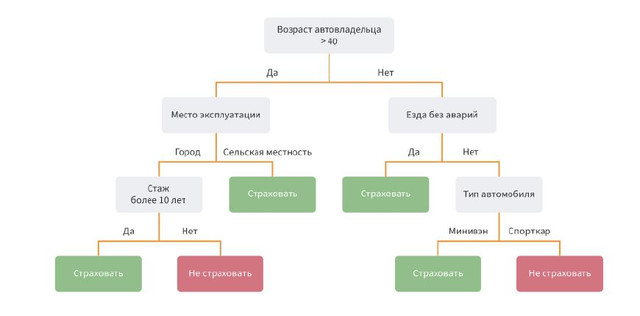

## Почему вам будет полезен этот семинар:

1. Вы познакомитесь с более продвинутыми методами машинного обучения, которые сейчас применяются для многих практических задач.
2. Узнаете, как происходит процесс настройки модели машинного обучения.
Это поможет вам грамотнее управлять проектами по машинному обучению и лучше понимать их специфику.
3. Поработаете с банковскими данными при помощи нового инструментария.



Мы будем работать с набором открытых банковских данных. Объекты - клиенты банка. Признаки - как характеристики самого клиента, так и связь клиента с банком. Целевая переменная - *Personal Loan*. Будем предсказывать, брал ли клиент заем, поэтому это задача **классификации**.

Описание признаков:
- ID: Идентификационный номер клиента
- Age: Возраст клиента
- Experience: Количество лет профессионального опыта
- Income: Годовой доход клиента
- ZIP Code: Почтовый индекс домашнего адреса
- Family: Размер семьи клиента
- CCAvg: Средние расходы по кредитным картам в месяц
- Education:  Уровень образования. 1: Undergrad; 2: Graduate; 3: Advanced/Professional
- Mortgage: Стоимость ипотеки на жилье, если таковая имеется
- Personal Loan: Принял ли данный клиент личный заем, предложенный в рамках последней кампании?
- Securities Account: Есть ли у клиента счет в ценных бумагах в банке?
- CD Account: Есть ли у клиента депозитный сертификат (CD) в банке?
- Online: Пользуется ли клиент услугами интернет-банкинга?
- Credit card: Пользуется ли клиент кредитной картой, выпущенной банком?


План занятия:
1. Разведочный анализ и подготовка данных
1. Решающие деревья: обучение моделей, выполнение предсказаний, оценка ошибки
1. Подбор гиперпараметров моделей

## Разведочный анализ и подготовка данных

Загрузим данные. Для чтения данных воспользуемся модулем `pandas`. `as pd` - создание сокращенного имени модуля для более быстрого обращения. Импортируем модуль:

In [1]:
# Импортируем библиотеки pandas и numpy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, f1_score, roc_curve, roc_auc_score

# Отключаем предупреждения
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

Вызываем функцию `read_csv` из модуля `pandas`:

In [2]:
# Загружаем данные, которые будем использовать
data = pd.read_csv('https://raw.githubusercontent.com/Gaechka777/data/main/Bank_Personal_Loan_Modelling.csv', index_col=0)

Посмотрим на первые несколько объектов с помощью функции `head`:

In [3]:
# Выводим первые пять строчек таблицы
data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


Одна строка (объект) - это пользователь банка. Столбцы задают характеристики, которые могут относиться и как пользователю, так и как банку.

Столбец "Personal Loan" - это наша целевая переменная, которая описывает, брал ли клиент личный заем. Мы решаем задачу классификации.

Число объектов и число признаков можно узнать через метод shape:

In [4]:
data.shape

(5000, 14)

ID не несет в себе никакой информации, кроме нумерации строк, поэтому можем его спокойно убрать из выборки

In [5]:
data = data.drop('ID', axis=1)

In [6]:
data.shape

(5000, 13)

Проведем небольшой разведочный анализ данных. Для начала выведем основные статистики по признакам:

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,5000.0,45.338400,11.463166,23.0,35.0,45.0,55.0,67.0
Experience,5000.0,20.104600,11.467954,-3.0,10.0,20.0,30.0,43.0
Income,5000.0,73.774200,46.033729,8.0,39.0,64.0,98.0,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.0,93437.0,94608.0,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.0,2.0,3.0,4.0
CCAvg,5000.0,1.937913,1.747666,0.0,0.7,1.5,2.5,10.0
Education,5000.0,1.881000,0.839869,1.0,1.0,2.0,3.0,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.0,0.0,101.0,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.0,0.0,0.0,1.0
Securities Account,5000.0,0.104400,0.305809,0.0,0.0,0.0,0.0,1.0


Давайте переименуем нашу целевую переменную для удобства.

In [11]:
data['target'] = data['Personal Loan']
data = data.drop('Personal Loan', axis=1)

* Есть ли пропуски в данных?
* Одинаков ли масштаб столбцов?

Построим гистограммы признаков:

In [12]:
# Служебная команда для правильного отображения графиков в jupyter notebook
%matplotlib inline

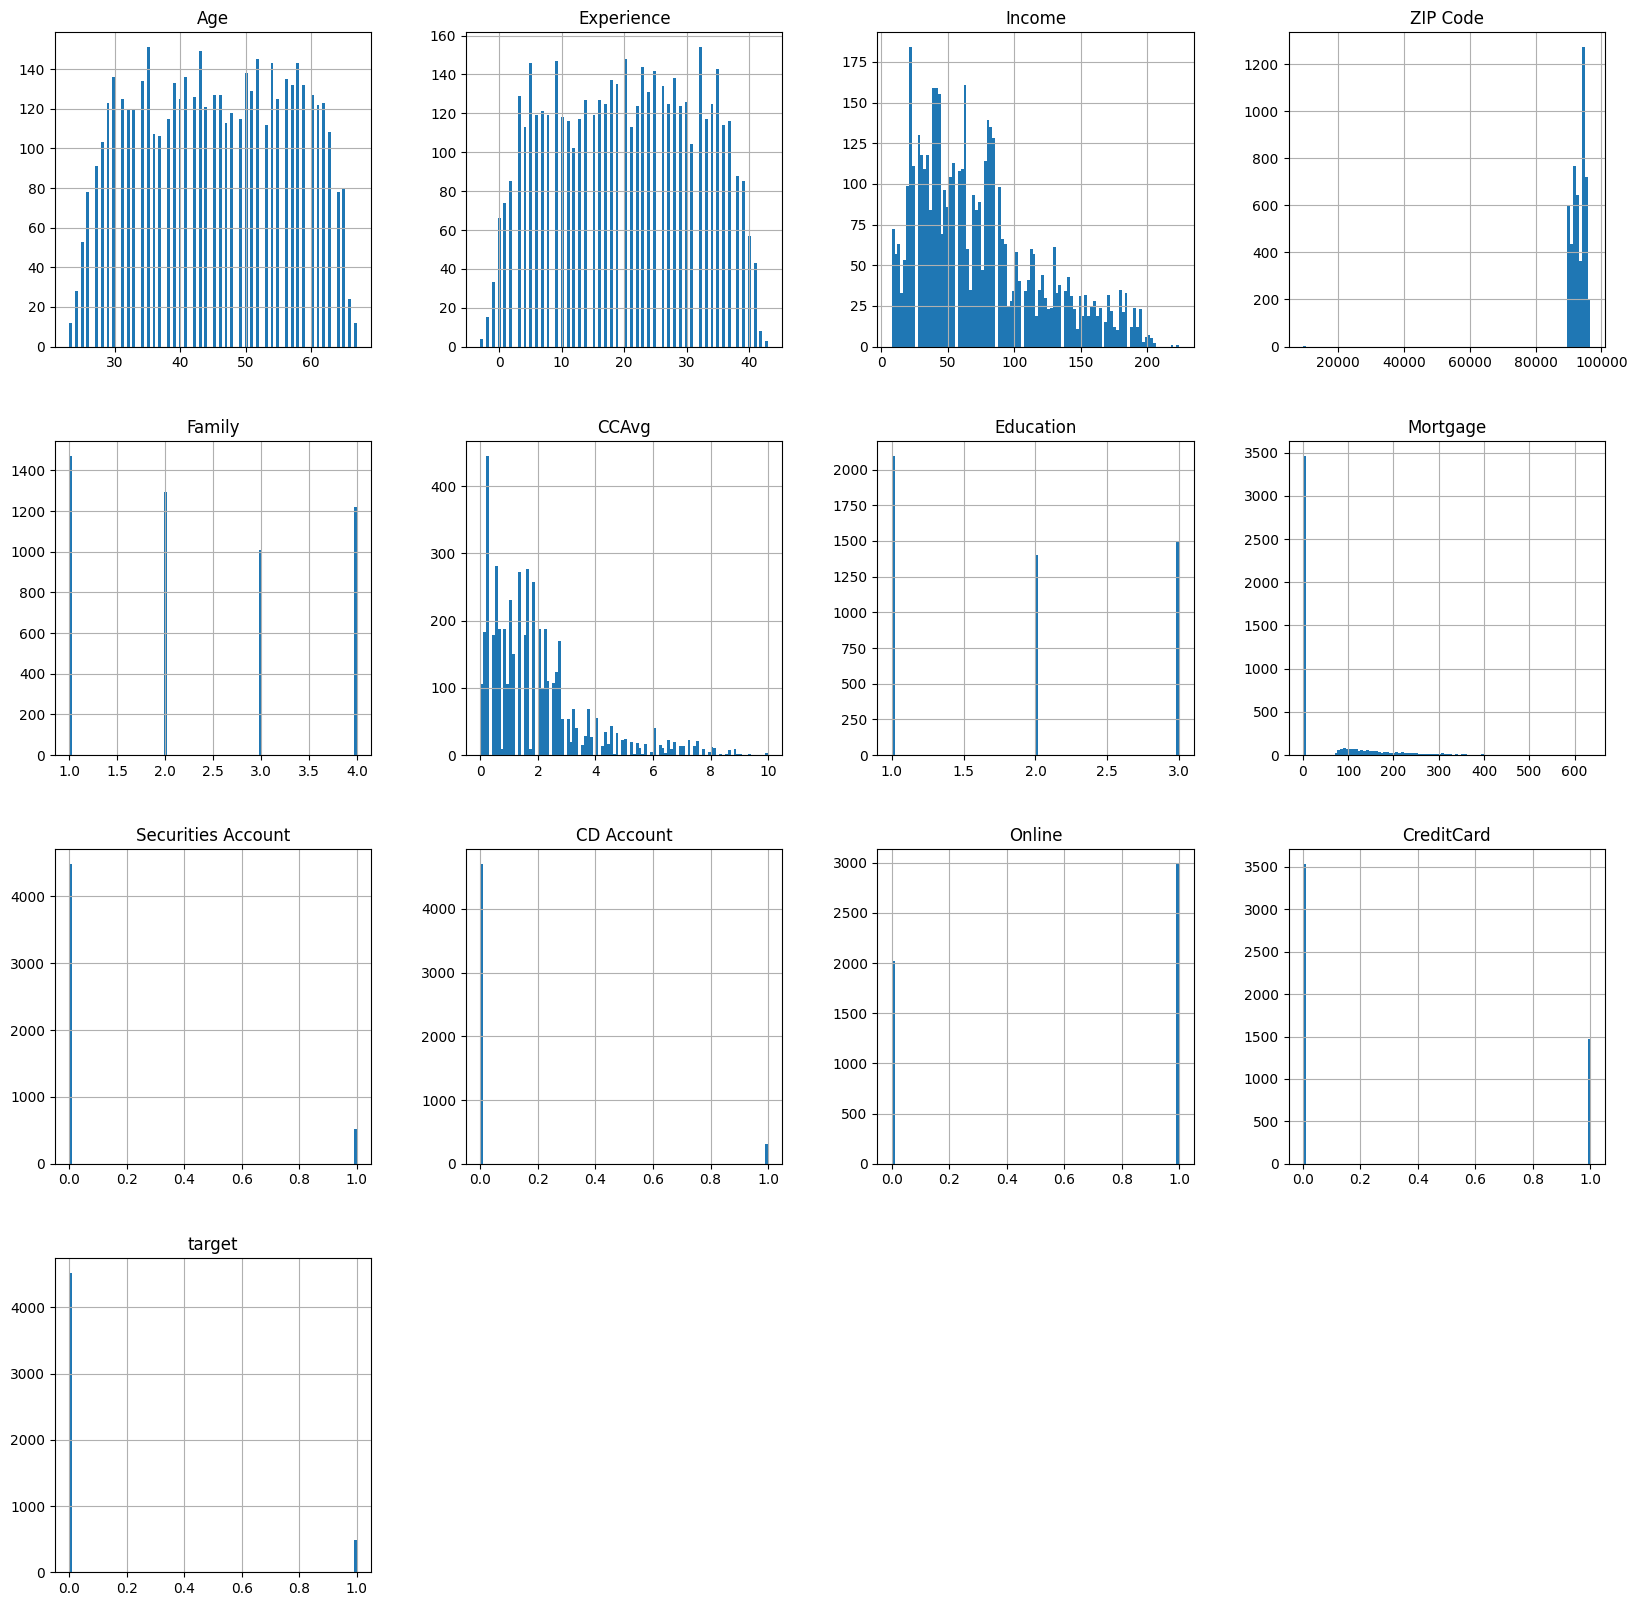

In [13]:
# Гистограммы с 100 интервалами
data.hist(figsize=(20, 20), bins=100)
pass

Отдельно проанализируем непрерывные и категориальные признаки. Будем относить к категориальным те признаки, у которых уникальных значений < 5, к непрерывным - остальные.

In [14]:
categorical=[col for col in data.columns if data[col].nunique()<=5]
continuous=[col for col in data.columns if data[col].nunique()>5]

In [15]:
print(categorical)
print(continuous)

['Family', 'Education', 'Securities Account', 'CD Account', 'Online', 'CreditCard', 'target']
['Age', 'Experience', 'Income', 'ZIP Code', 'CCAvg', 'Mortgage']


Мы хотим убрать из рассмотрения целевую переменную, пока нам интересны сами признаки.

In [16]:
categorical.remove("target")

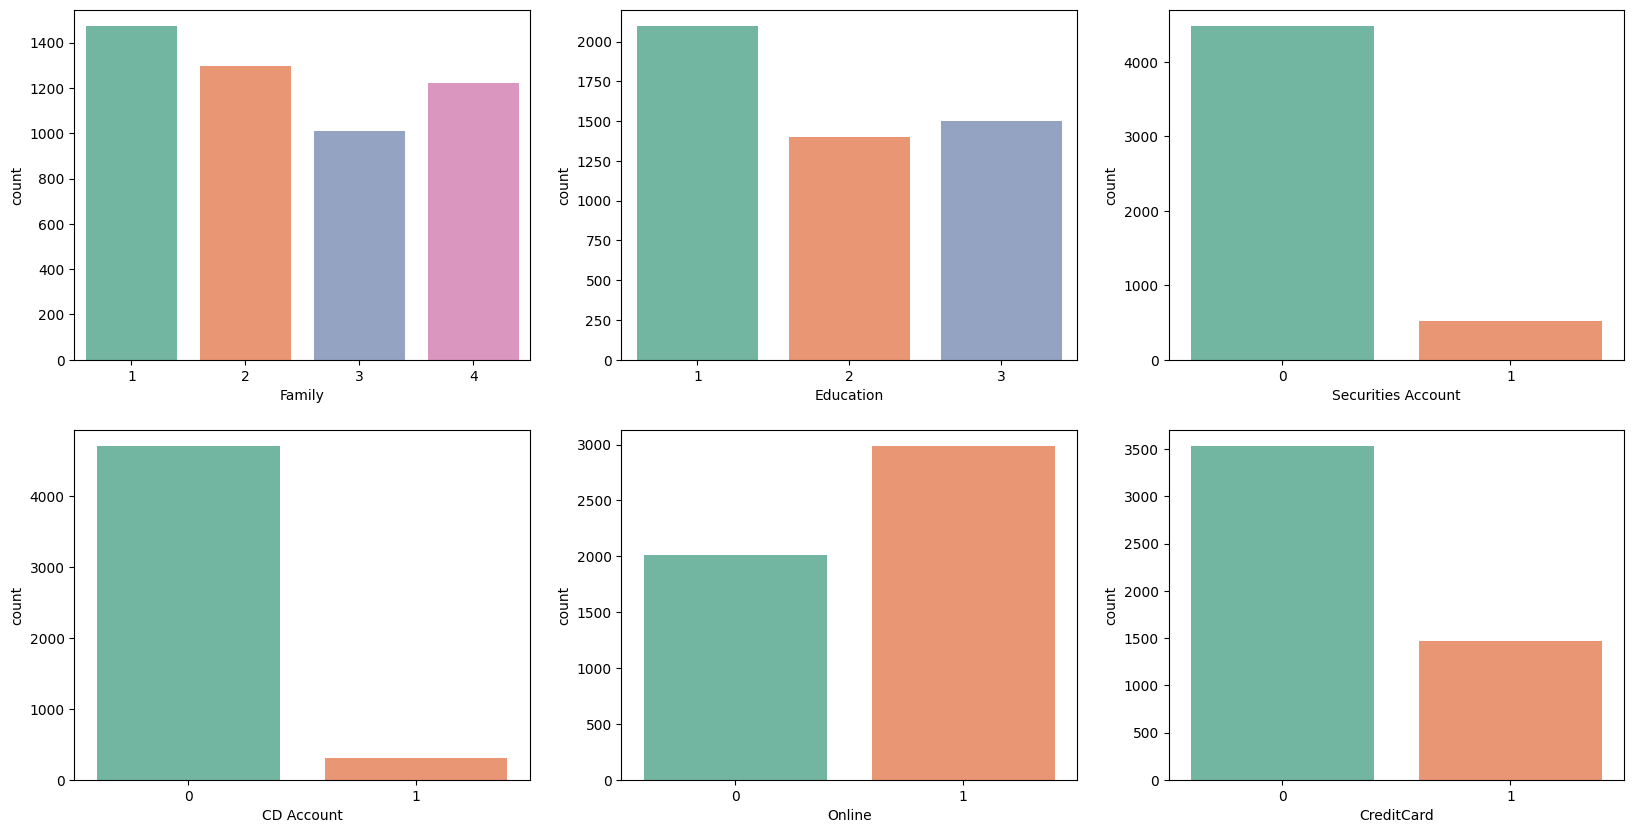

In [17]:
fig=plt.figure(figsize=(20,10))
for i,col in enumerate(categorical):
    ax=fig.add_subplot(2,3,i+1)
    sns.countplot(x=col, data=data, palette = "Set2")

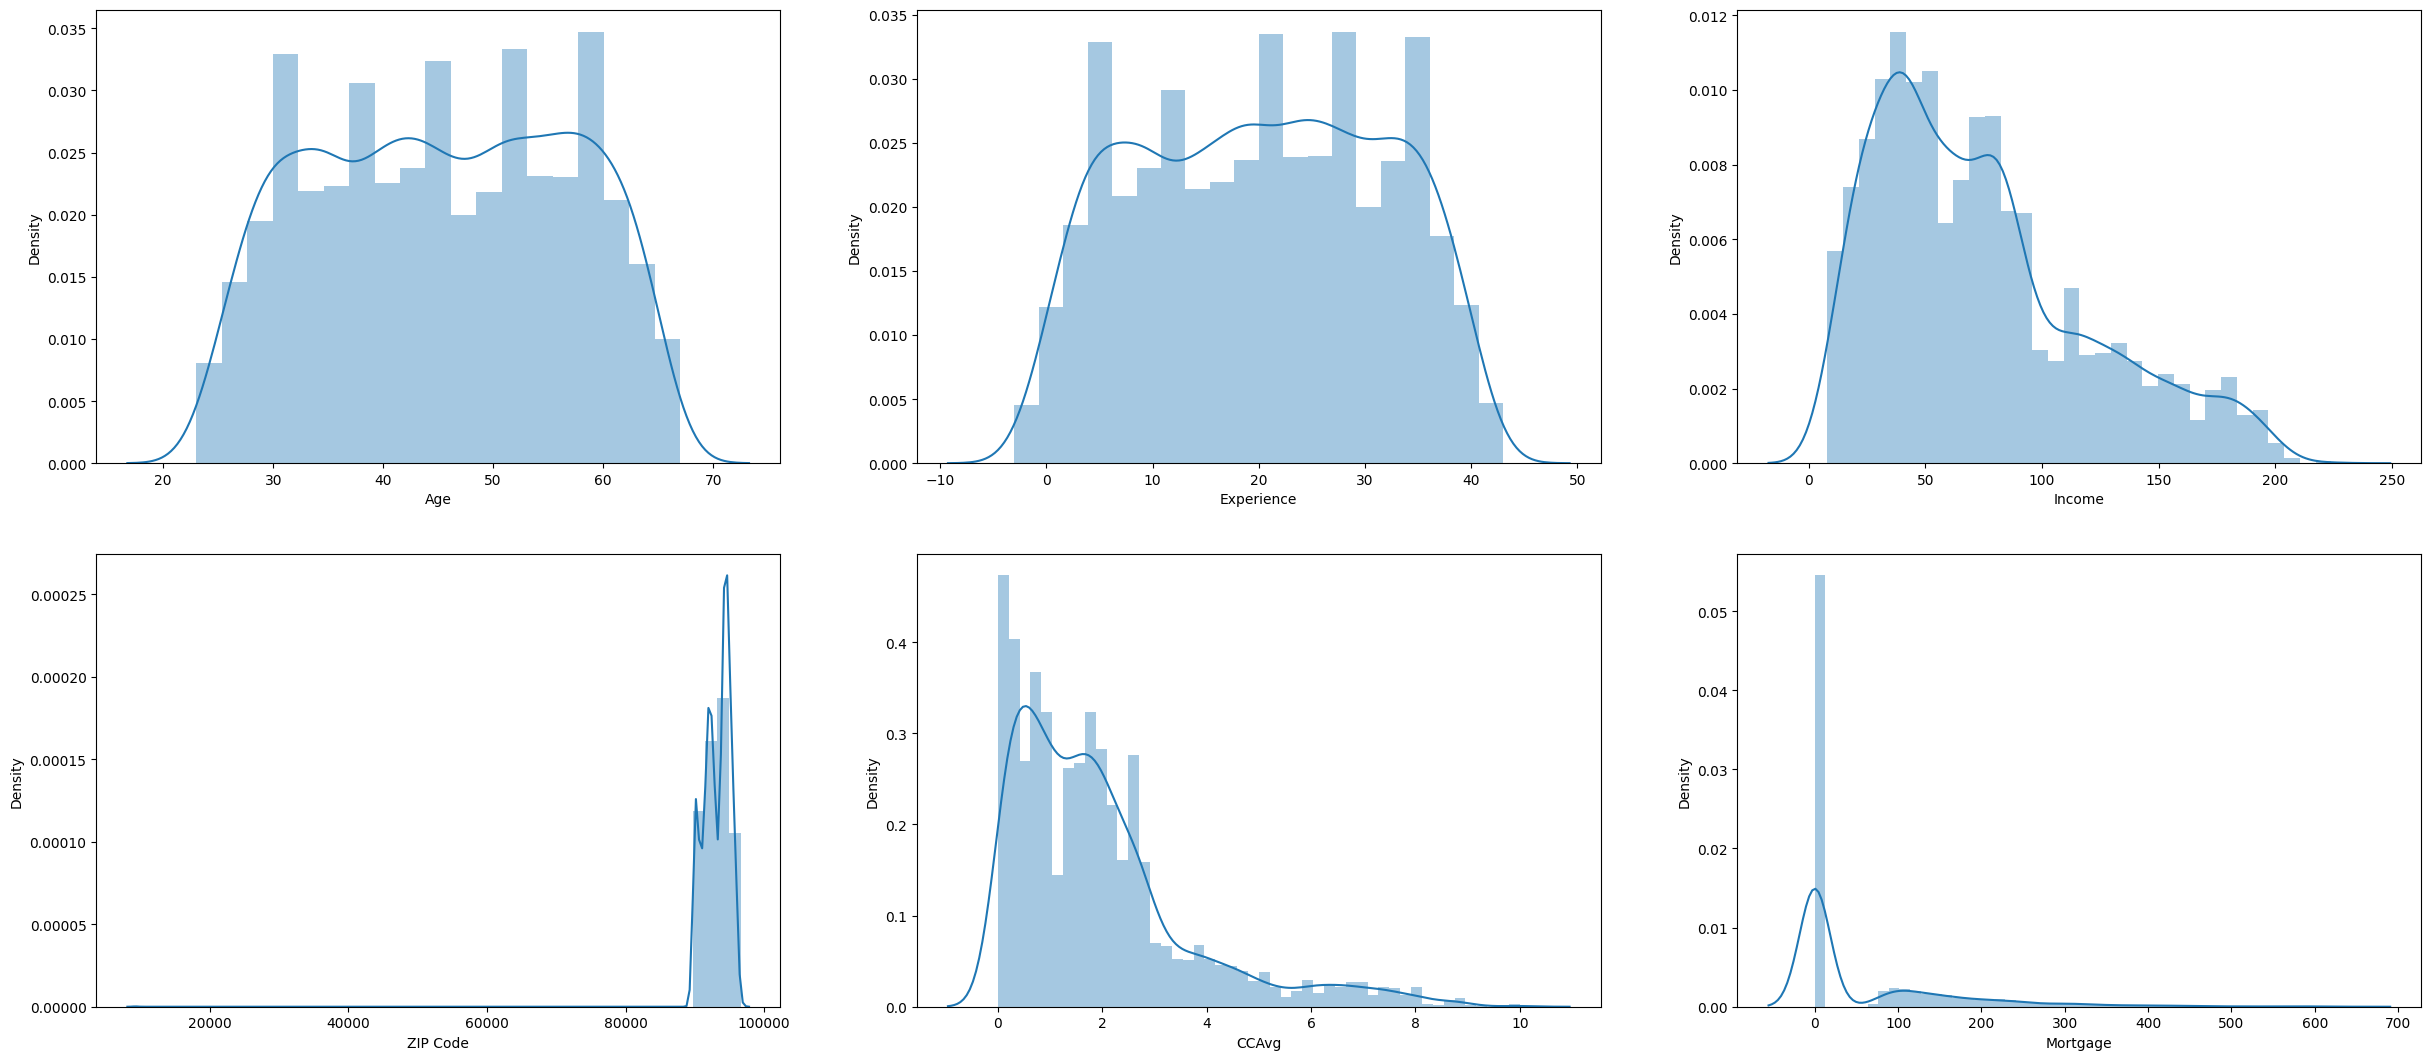

In [18]:
fig=plt.figure(figsize=(30,20))
for i,col in enumerate(continuous):
    ax=fig.add_subplot(3,3,i+1)
    sns.distplot(data[col])

Рассмотрим гистограмму отдельно для целевой переменной.

<Axes: xlabel='target', ylabel='count'>

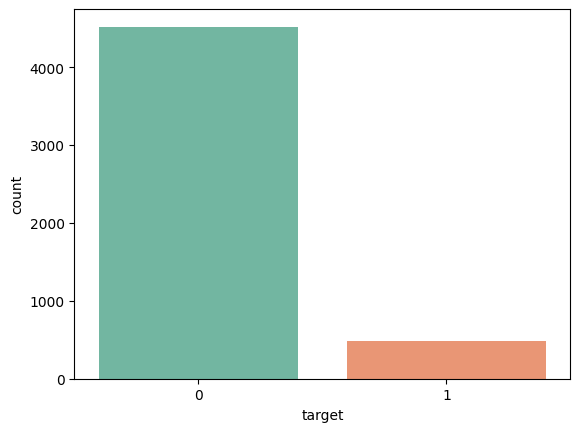

In [19]:
sns.countplot(x='target', data=data, palette = "Set2")

Как можно заметить по гистограмме, выборка является несбалансированной, но внутри наших методов есть реализованные функции, способные с этим справляться, будем применять их в дальнейшем.

In [20]:
data.columns[:-1]

Index(['Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Securities Account', 'CD Account', 'Online',
       'CreditCard'],
      dtype='object')

(13.5, -0.5)

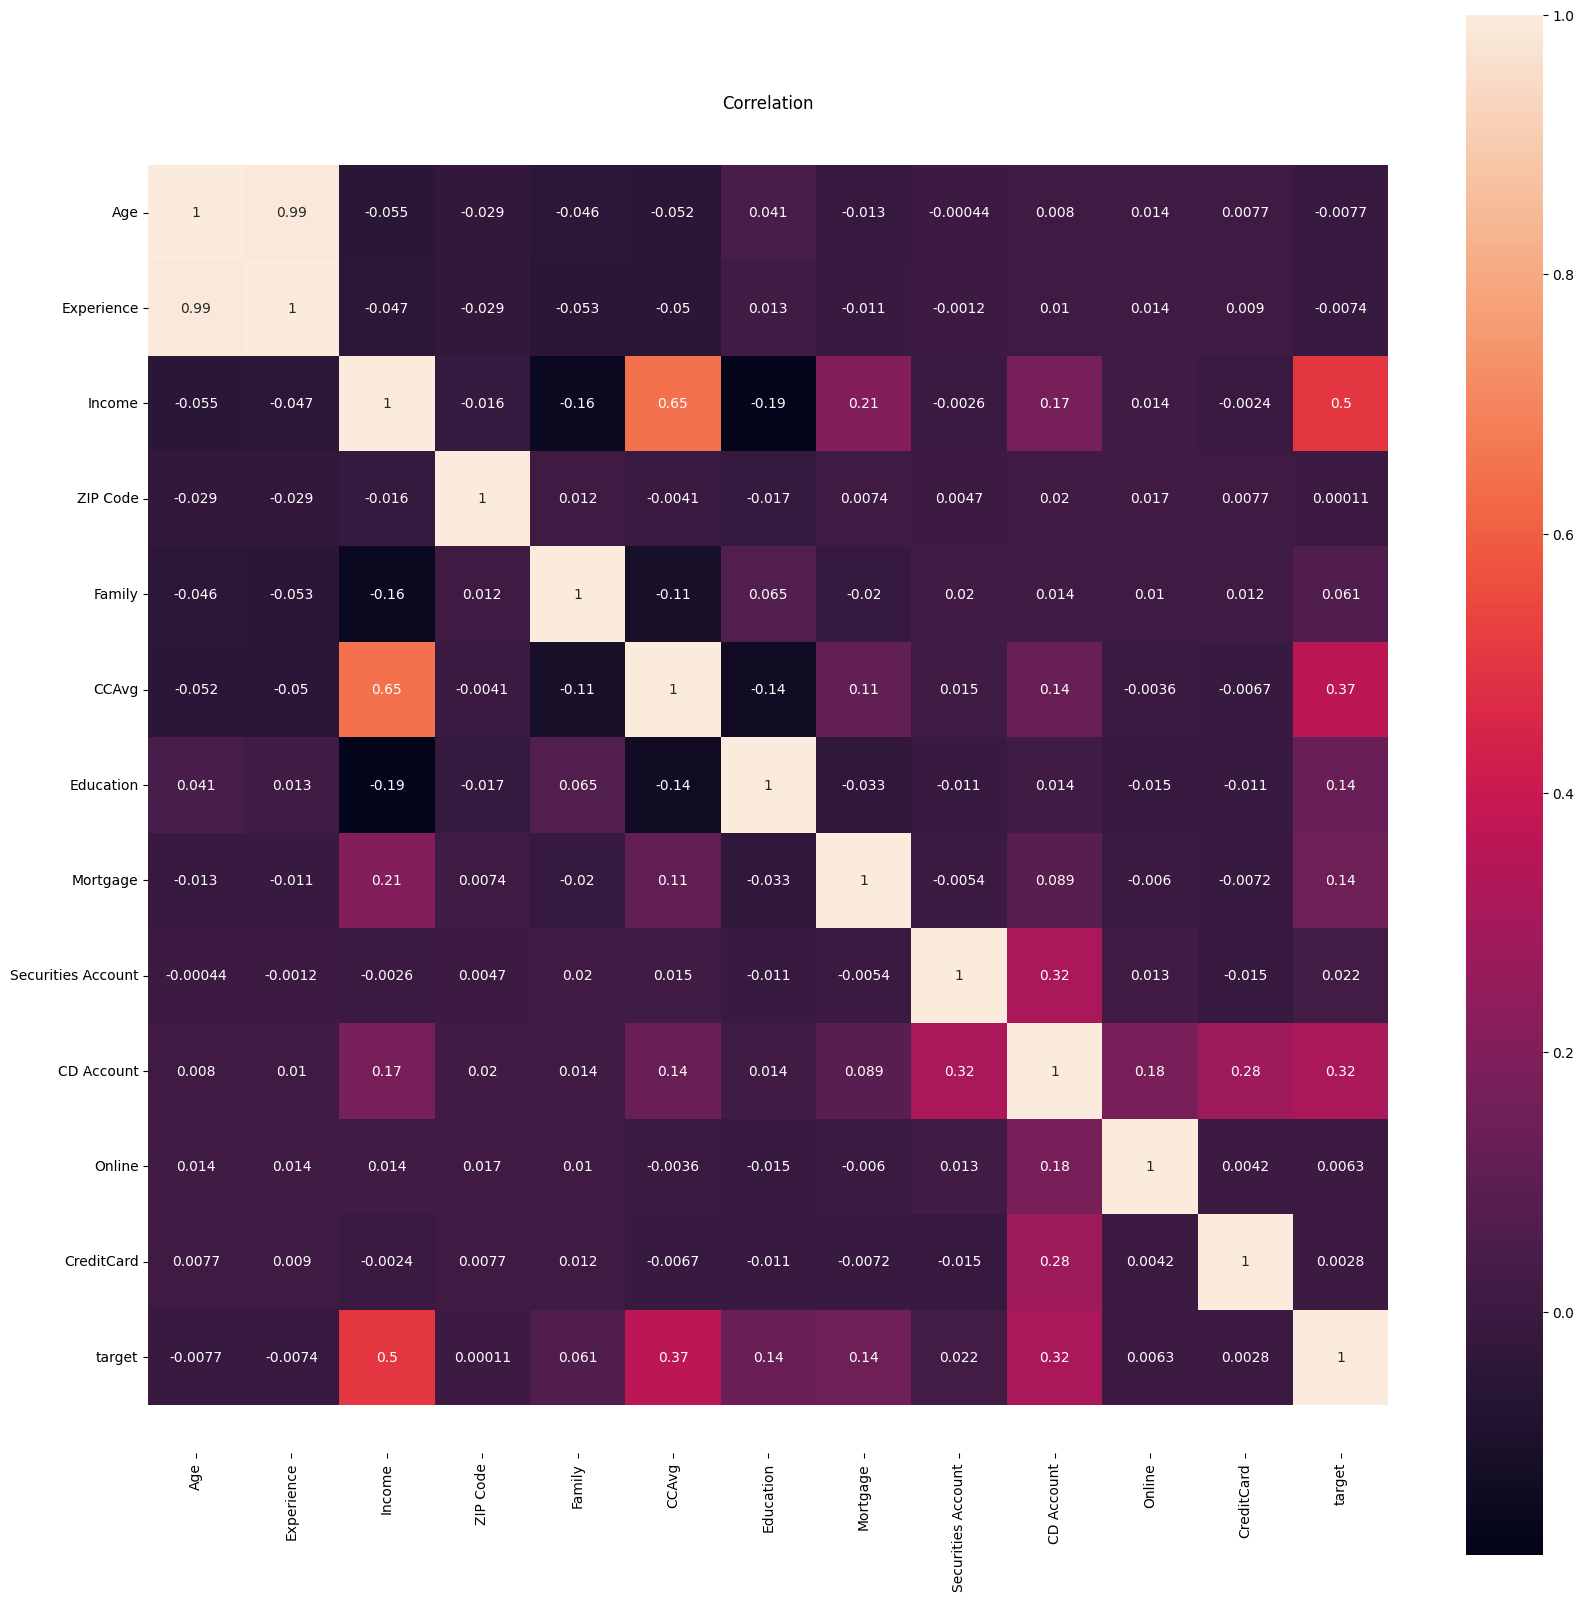

In [21]:
corr = data.corr()
plt.figure(figsize=(20,20))
plt.title('Correlation')
ax=sns.heatmap(corr, annot=True, square=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Можно заметить из данной матрицы корреляций, что признаки "CD Account", "CCAvg", "Income" достаточно сильно по сравнению с остальными влияют на результат. Судя по описанию данных признаков, можно заметить, что все они связаны с доходами или расходами клиента, что напрямую влияет на принятие решения взятия займа. Также важным моментом является корреляция признака "Age" c "Experience", следовательно, один из них можно удалить из рассмотрения, как мы и сделаем дальше.

In [22]:
data = data.drop('Age', axis=1)

Подготовим проанализированные данные

In [23]:
X = data.drop('target', axis=1) # Определяем признаки
y = data["target"] # Определяем целевую переменную

### **Задача 1.** Разбиение на обучение и тест

Теперь у нас есть отдельно объекты, хранящиеся в переменной X, и отдельно целевые значения, хранящиеся в переменной y. Разделим данные на обучающую и тестовую части: 70% отдаем на обучение, 30% - в тест, фиксируем `random_state` 42.

**Давайте попробуем выполнить данное задание с помощью модели Mistral. Чтобы воспользоваться чатом, есть несколько вариантов:**


1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого браузера;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.

Чтобы выполнить это задание вам необходимо скопировать пропмт без слова промпт в чат с мистралью.

**Промпт:**

Разбейте датасет, который описывается X и y, на тестовую и обучающую выборки при фиксированном состоянии 42 и в пропорции 70:30.

In [24]:
# Импортируем библиотеку для разделения выборки на тестовую и обучающую
from sklearn.model_selection import train_test_split

In [25]:
# Делим выборку на обучающую и тестовую и фиксируем random_state

# Ваш код
# X_train, X_test, y_train, y_test =
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Построение линейной модели

В качестве базового решения обучим линейную модель.

In [26]:
from sklearn.linear_model import LogisticRegression

In [27]:
def evaluate(y, preds, stage='test', model_name='', need_report=True, need_roc_auc=False, y_prob=None):
    print(f"Точность ({stage}):", accuracy_score(y, preds))
    print(f"F1 ({stage}):", f1_score(y, preds))

    if need_report:
        print(classification_report(y, preds))

    if need_roc_auc:
        fpr, tpr, thresholds = roc_curve(y, y_prob)

        auc = roc_auc_score(y, y_prob)

        plt.plot(fpr, tpr, label=f'{model_name} {stage} (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('Ложные положительные результаты ')
        plt.ylabel('Истинные положительные результаты ')
        plt.title('ROC Кривая')
        plt.legend()
        plt.show()

###Метрики качества классификации

**Accuracy**

Accuracy — это метрика, которая показывает, насколько часто модель правильно предсказывает метки классов для данных. Простыми словами, это доля правильных предсказаний среди всех предсказаний.

Формула accuracy выглядит следующим образом:

$$ \text{Accuracy} = \frac{\text{Количество правильных предсказаний}}{\text{Общее количество предсказаний}} $$

### Пример

Предположим, у вас есть модель классификации, которая предсказывает, является ли электронное письмо спамом (1) или не спамом (0). Вы протестировали модель на 100 письмах и получили следующие результаты:

- 80 писем были правильно классифицированы (50 как не спам и 30 как спам).
- 20 писем были неправильно классифицированы (10 как не спам и 10 как спам).

Тогда accuracy модели будет:

$$ \text{Accuracy} = \frac{80}{100} = 0.8 $$

Или в процентах:

$$ \text{Accuracy} = 80\% $$


Если задача сбалансирована и вас интересуют как положительные, так и отрицательные прогнозы, accuracy - хороший выбор. Если присутствует несбалансированность (много отрицательных случаев по сравнению с положительными) и нам нужно сосредоточиться на положительных случаях, то лучше обратиться к F1.

Чтобы ввести эту метрику, нам нужно познакомиться с матрицей ошибок.

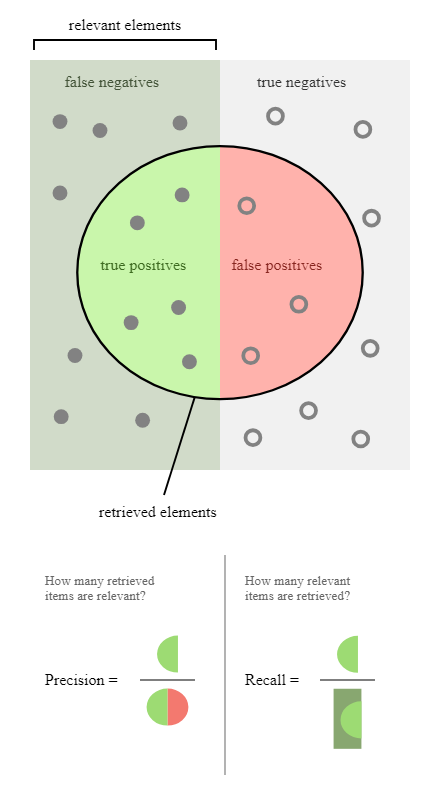

<!-- ###Метрики качества классификации

**Accuracy**

Это показатель, который определяет, насколько близко измеренное значение к истинному или принятому значению физической величины.

$$Accuracy = \frac{(Measured\ Value – True\ Value)}{True\ Value}$$

Если задача сбалансирована и вас интересуют как положительные, так и отрицательные прогнозы, точность - хороший выбор. Если проблема несбалансирована (много отрицательных случаев по сравнению с положительными) и нам нужно сосредоточиться на положительных случаях, то лучше обратиться к F1.

Чтобы ввести эту метрику, нам нужно познакомиться с матрицей ошибок. -->

<!-- <img src="https://raw.githubusercontent.com/Gaechka777/data/main/Precisionrecall.svg" alt="Image" width="300"> -->

**F1 score**

Данная метрика позволяет уследить баланс между двумя метриками выше. Она становится низкой, если или precision или recall низкий. Большие значения F1 можно получить, только когда оба precision и recall имеют большие значения. Таким образом F1 показывает некоторый худший сценарий между precision и recall. Ее можно рассчитать по формуле ниже:

$$
F1 = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}
$$

Пример:

| Идентификатор документа | Истинный класс | Вывод классификатора |
|-------------------------|-----------------|----------------------|
| D1                      | Спорт           | Спорт                |
| D2                      | Спорт           | Спорт                |
| D3                      | Не спорт        | Спорт                |
| D4                      | Спорт           | Не спорт             |
| D5                      | Не спорт        | Не спорт             |
| D6                      | Спорт           | Не спорт             |
| D7                      | Не спорт        | Спорт                |
| D8                      | Не спорт        | Не спорт             |
| D9                      | Не спорт        | Не спорт             |
| D10                     | Спорт           | Спорт                |
| D11                     | Спорт           | Спорт                |
| D12                     | Спорт           | Не спорт             |

Давайте рассмотрим пример с документами, классифицированными как «Спорт» или «Не спорт», чтобы лучше объяснить определения истинно положительных результатов (TP), истинно отрицательных результатов (TN), ложноположительных результатов (FP) и ложноотрицательных результатов (FN) в контексте классификации:


*Истинно положительные (TP):* Документы, которые были точно отнесены к категории «Спорт» и которые на самом деле были о спорте. Документы D1, D2, D10 и D11 в этом сценарии являются примерами TP.


*Истинно отрицательные (TN):* True Negatives — это те случаи, когда документ был правильно помечен как «Не спорт» и не имел никакого отношения к спорту. В этом случае TN демонстрируется документами D5, D8 и D9.


*Ложноположительные срабатывания (FP):* Документы, которые были ошибочно отнесены к категории «Спорт», хотя они не имели никакого отношения к спорту. Вот несколько примеров FP, документы D3 и D7.


*Ложноотрицательные срабатывания (FN):* Примеры документов, которые были ошибочно помечены как «Не спорт», но на самом деле они были о спорте. Документы D4, D6 и D12 в этом случае являются примерами FN.


Учитывая эти подсчеты:

TP = 4, TN = 3, FP = 2, FN = 3


Наконец, precision и recall рассчитываются следующим образом:


$$Precision = \frac{TP}{TP+FP} = \frac{2}{3}$$



$$Recall = \frac{TP}{TP+FN} = \frac{4}{7}$$


Теперь, используя precision и recall, мы можем посчитать F1-score:

$$
F1 = 2 \cdot \frac{0.67 \cdot 0.57}{0.67 + 0.57} \approx 0.44
$$


**ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**

Является важным показателем для оценки качества бинарных классификаторов, особенно когда важен не класс, а вероятность класса. Она используется для оценки способности модели различать положительные и отрицательные классы.

- Рассмотрим первую часть ROC-кривая (Receiver Operating Characteristic curve):

ROC-кривая строится на основе двух параметров:
1. Уровень истинных положительных результатов (TPR) означает соотношение правильно предсказанных положительных меток из всех положительных меток.

$$TPR = \frac{TP}{TP + FN} $$
​

2. Частота ложных положительных результатов (FPR) относится к соотношению неверно предсказанных положительных меток из всех отрицательных меток.

$$FPR
= \frac{FP}{FP + TN} $$
​

ROC-кривая строится путем изменения порога классификации и нанесения TPR на ось Y и FPR на ось X.

Что означает изменение порога?

Классификатор нам выдает вероятности для каждого объекта принадлежности к определенному классу. Рассмотрим таблицу выше заново, на самом деле там не сразу стоят такие классы, это уже преобразованные вероятности с порогом 0.5

| Идентификатор документа | Истинный класс | Вывод классификатора | Вероятность |
|-------------------------|-----------------|----------------------| ----------------------|
| D1                      | Спорт           | Спорт                | 0.8 |
| D2                      | Спорт           | Спорт                | 0.9 |
| D3                      | Не спорт        | Спорт                | 0.6 |
| D4                      | Спорт           | Не спорт             | 0.4 |
| D5                      | Не спорт        | Не спорт             | 0.1 |
| D6                      | Спорт           | Не спорт             | 0.4 |
| D7                      | Не спорт        | Спорт                | 0.55|
| D8                      | Не спорт        | Не спорт             | 0.2 |
| D9                      | Не спорт        | Не спорт             | 0.2 |
| D10                     | Спорт           | Спорт                | 0.7 |
| D11                     | Спорт           | Спорт                | 0.95|
| D12                     | Спорт           | Не спорт             | 0.44|

То есть все, что больше 0.5 перевелось в "Спорт", все меньше - "Не спорт". Варьируя порог, высчитываются новые значения TP, FN, FP, TN. Следовательно, мы получаем по этим точкам график в зависимости от порога.

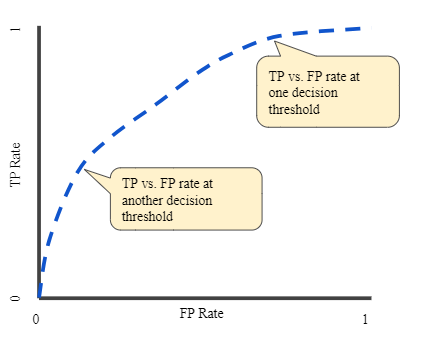

- Вторая часть AUC (Area Under Curve):

AUC означает площадь под кривой ROC. Он измеряет всю двумерную область под всей кривой ROC от (0,0) до (1,1).

1. AUC = 1 означает идеальную модель, которая правильно классифицирует все положительные и отрицательные случаи.
2. AUC = 0.5 означает, что модель не лучше случайного угадывания.
3. AUC < 0.5 означает, что модель хуже случайного угадывания (что редко встречается на практике).

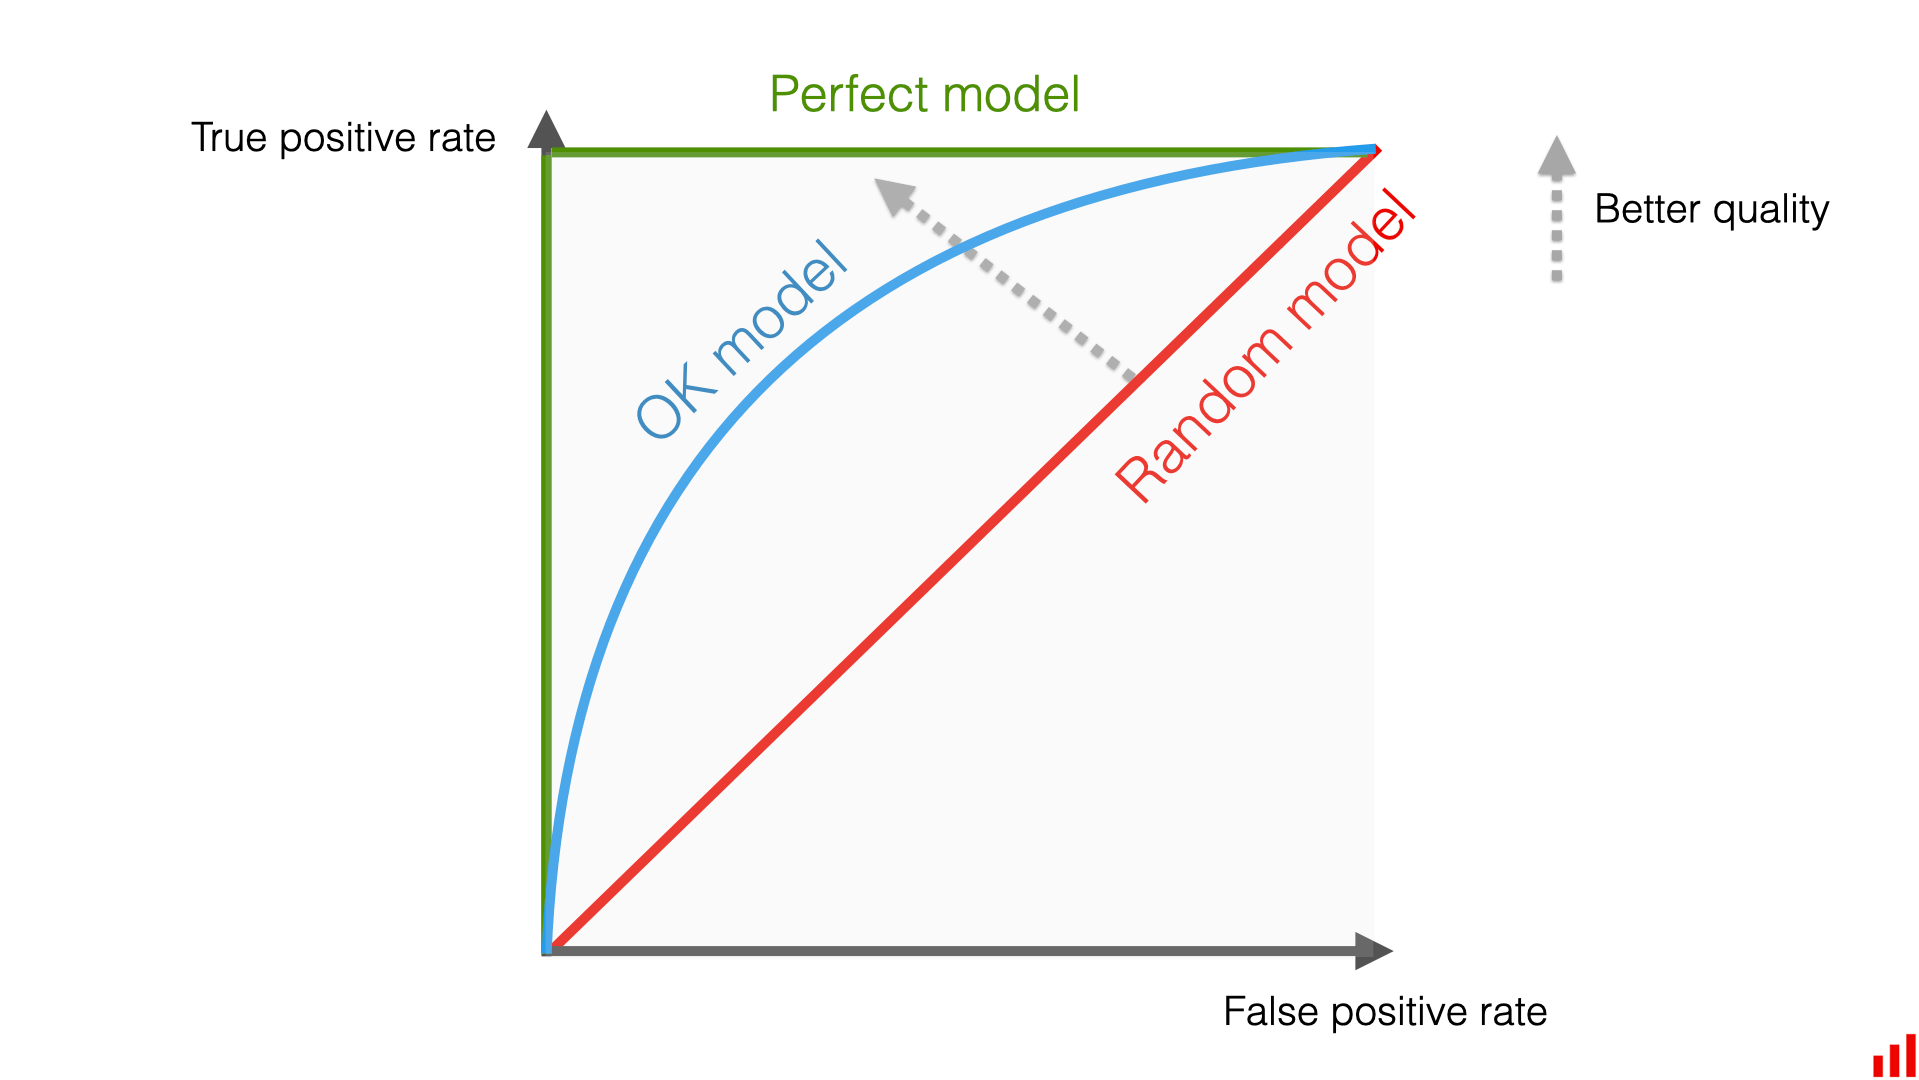

**Вопрос:** Приведите пример, когда AUC может стать меньше 0.5?

###Обучим модель

Выполняем шаги обучения, предсказания и оценивания средней ошибки:

Точность (train): 0.8774285714285714
F1 (train): 0.5714285714285714
              precision    recall  f1-score   support

           0       0.99      0.88      0.93      3177
           1       0.42      0.89      0.57       323

    accuracy                           0.88      3500
   macro avg       0.70      0.88      0.75      3500
weighted avg       0.93      0.88      0.90      3500



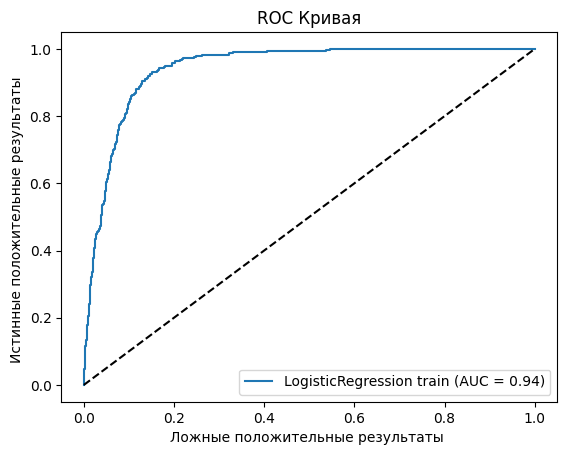

In [28]:
# Обучение
model = LogisticRegression(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Предсказания
preds_train = model.predict(X_train)
preds_test = model.predict(X_test)

# Оценивание ошибки на трейне
y_prob_train = model.predict_proba(X_train)[:, 1]
evaluate(y_train, preds_train, stage='train', model_name='LogisticRegression', need_report=True,
         need_roc_auc=True, y_prob=y_prob_train)

Точность (test): 0.868
F1 (test): 0.5857740585774058
              precision    recall  f1-score   support

           0       0.99      0.87      0.92      1343
           1       0.44      0.89      0.59       157

    accuracy                           0.87      1500
   macro avg       0.71      0.88      0.75      1500
weighted avg       0.93      0.87      0.89      1500



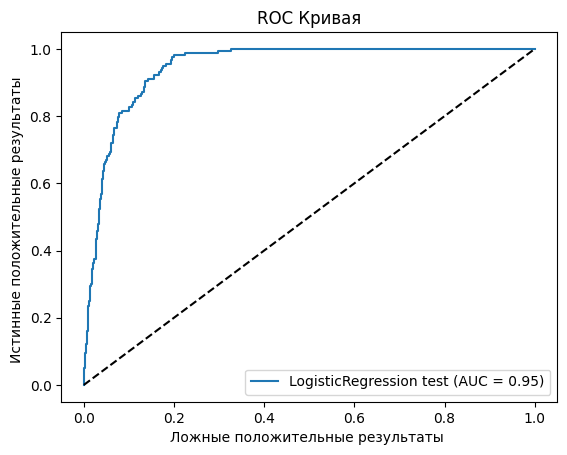

In [29]:
# Оценивание ошибки на тесте
y_prob_test = model.predict_proba(X_test)[:, 1]
evaluate(y_test, preds_test, stage='test', model_name='LogisticRegression', need_report=True,
         need_roc_auc=True, y_prob=y_prob_test)

## Модель Дерево решений

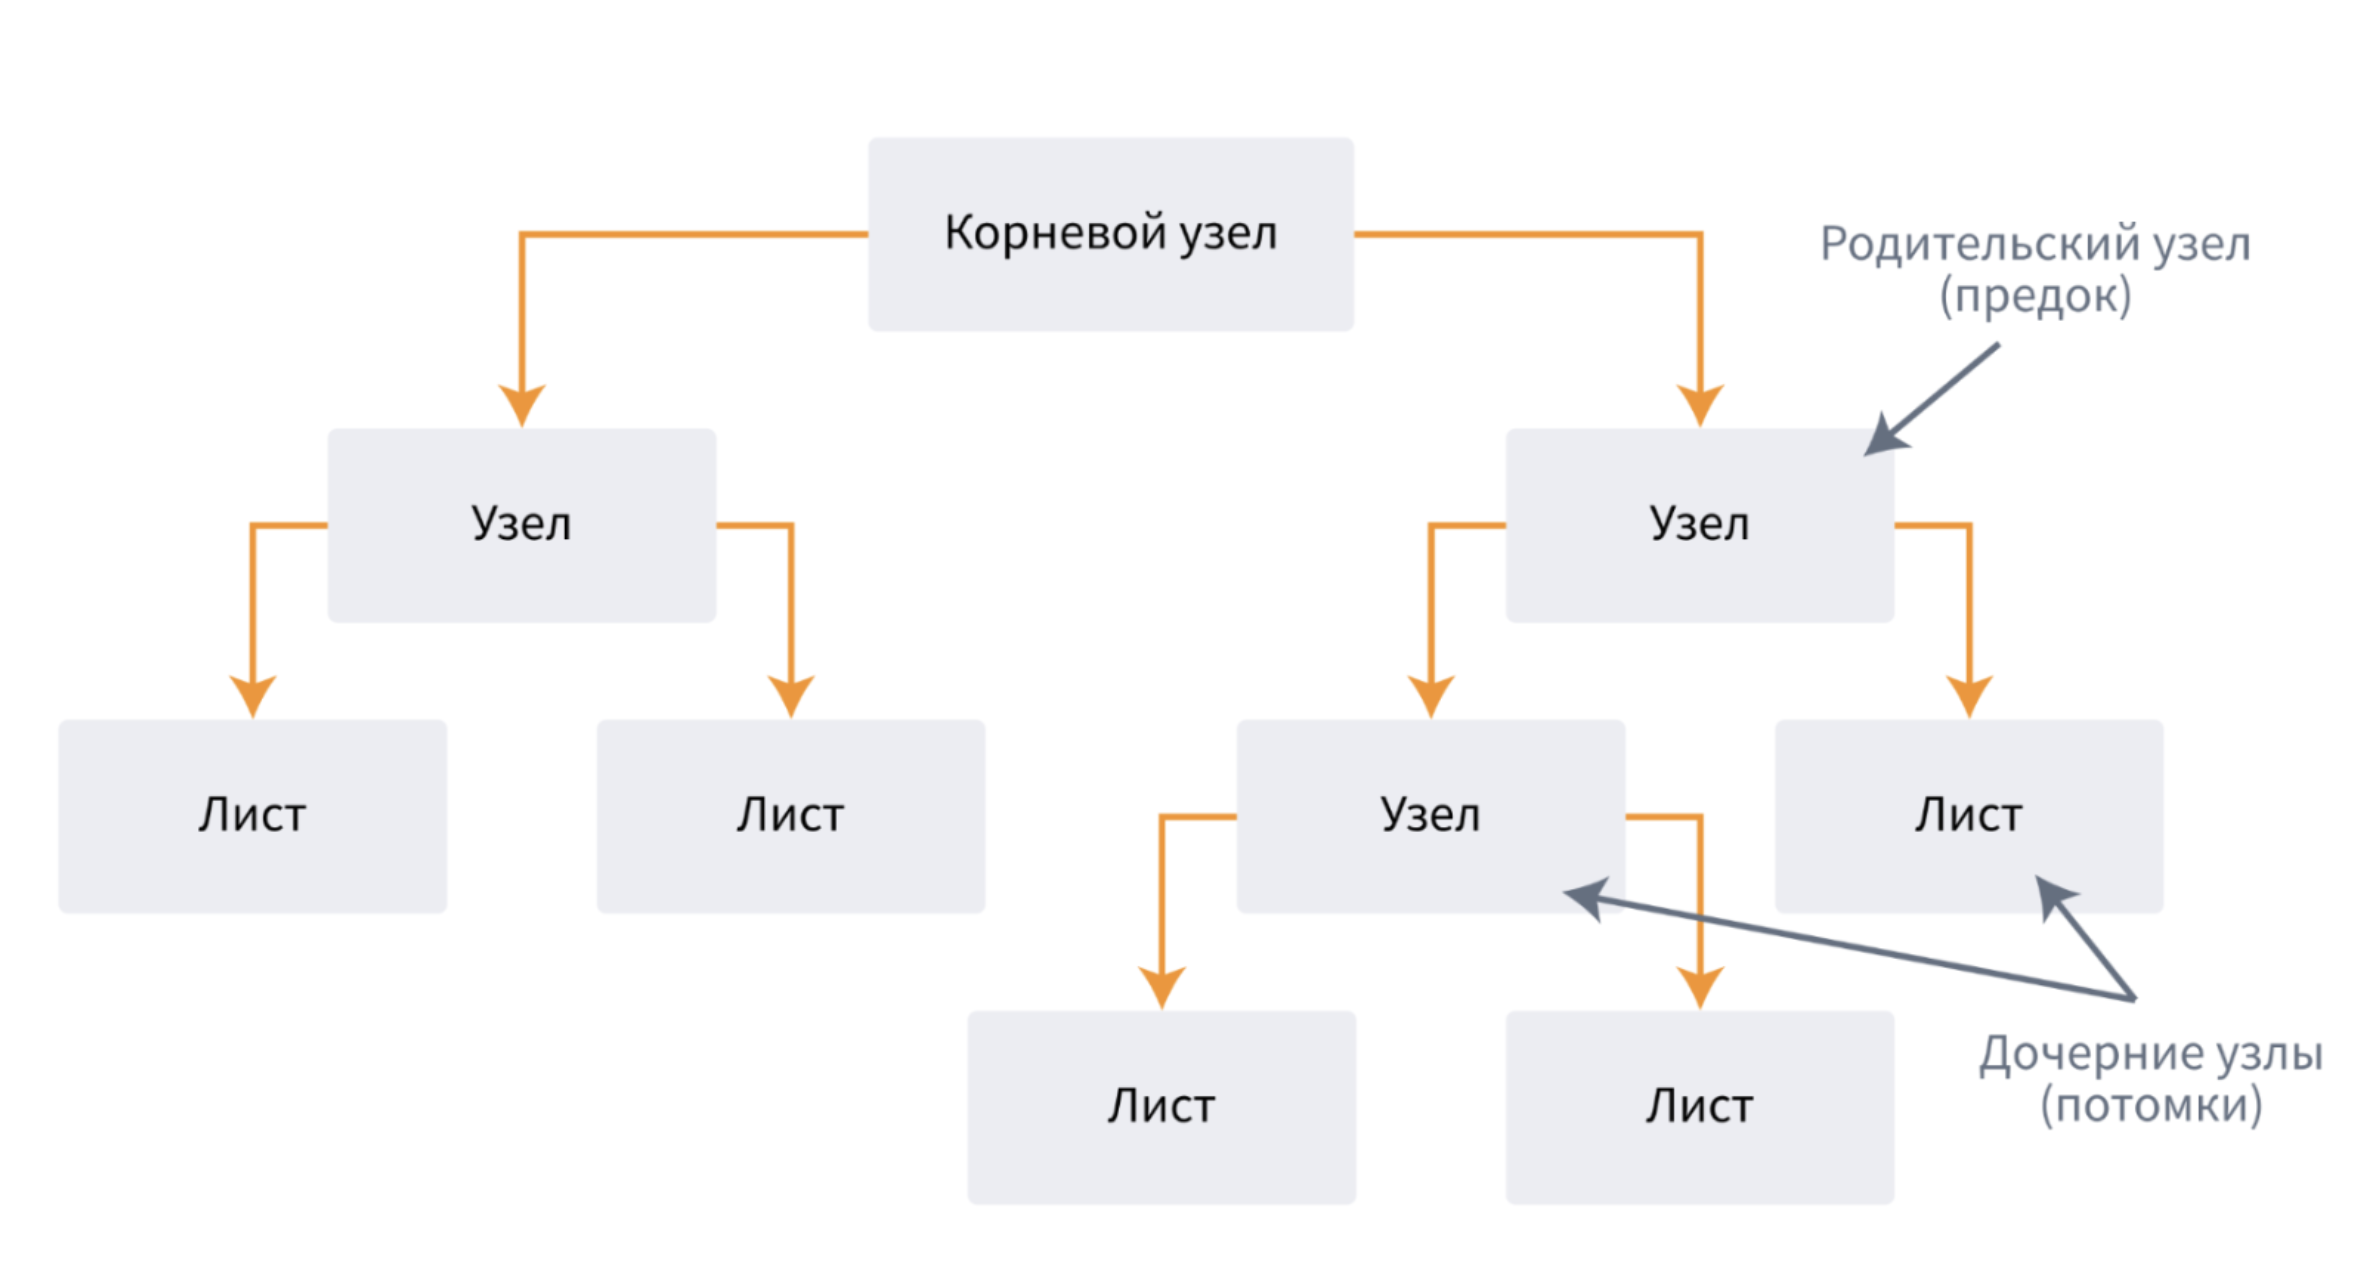

Дерево решений - это иерархическая структура, состоящая из элементов двух типов — узлов (node) и листьев (leaf).

В корневом узле находятся все объекты нашей обучающей выборки, а далее, в каждом последующем узле происходит её разбиение на подмножества, в соответствии с некоторыми правилами. Пример такого правила - проверка величины признака на преодоление заданного порога. В итоге элементы обучающей выборки оказываются разделены на несколько конечных подмножеств-листьев, каждому из которых ставится в соответствие некоторая величина, которой мы и будем предсказывать значение точек, попавших в этот лист.

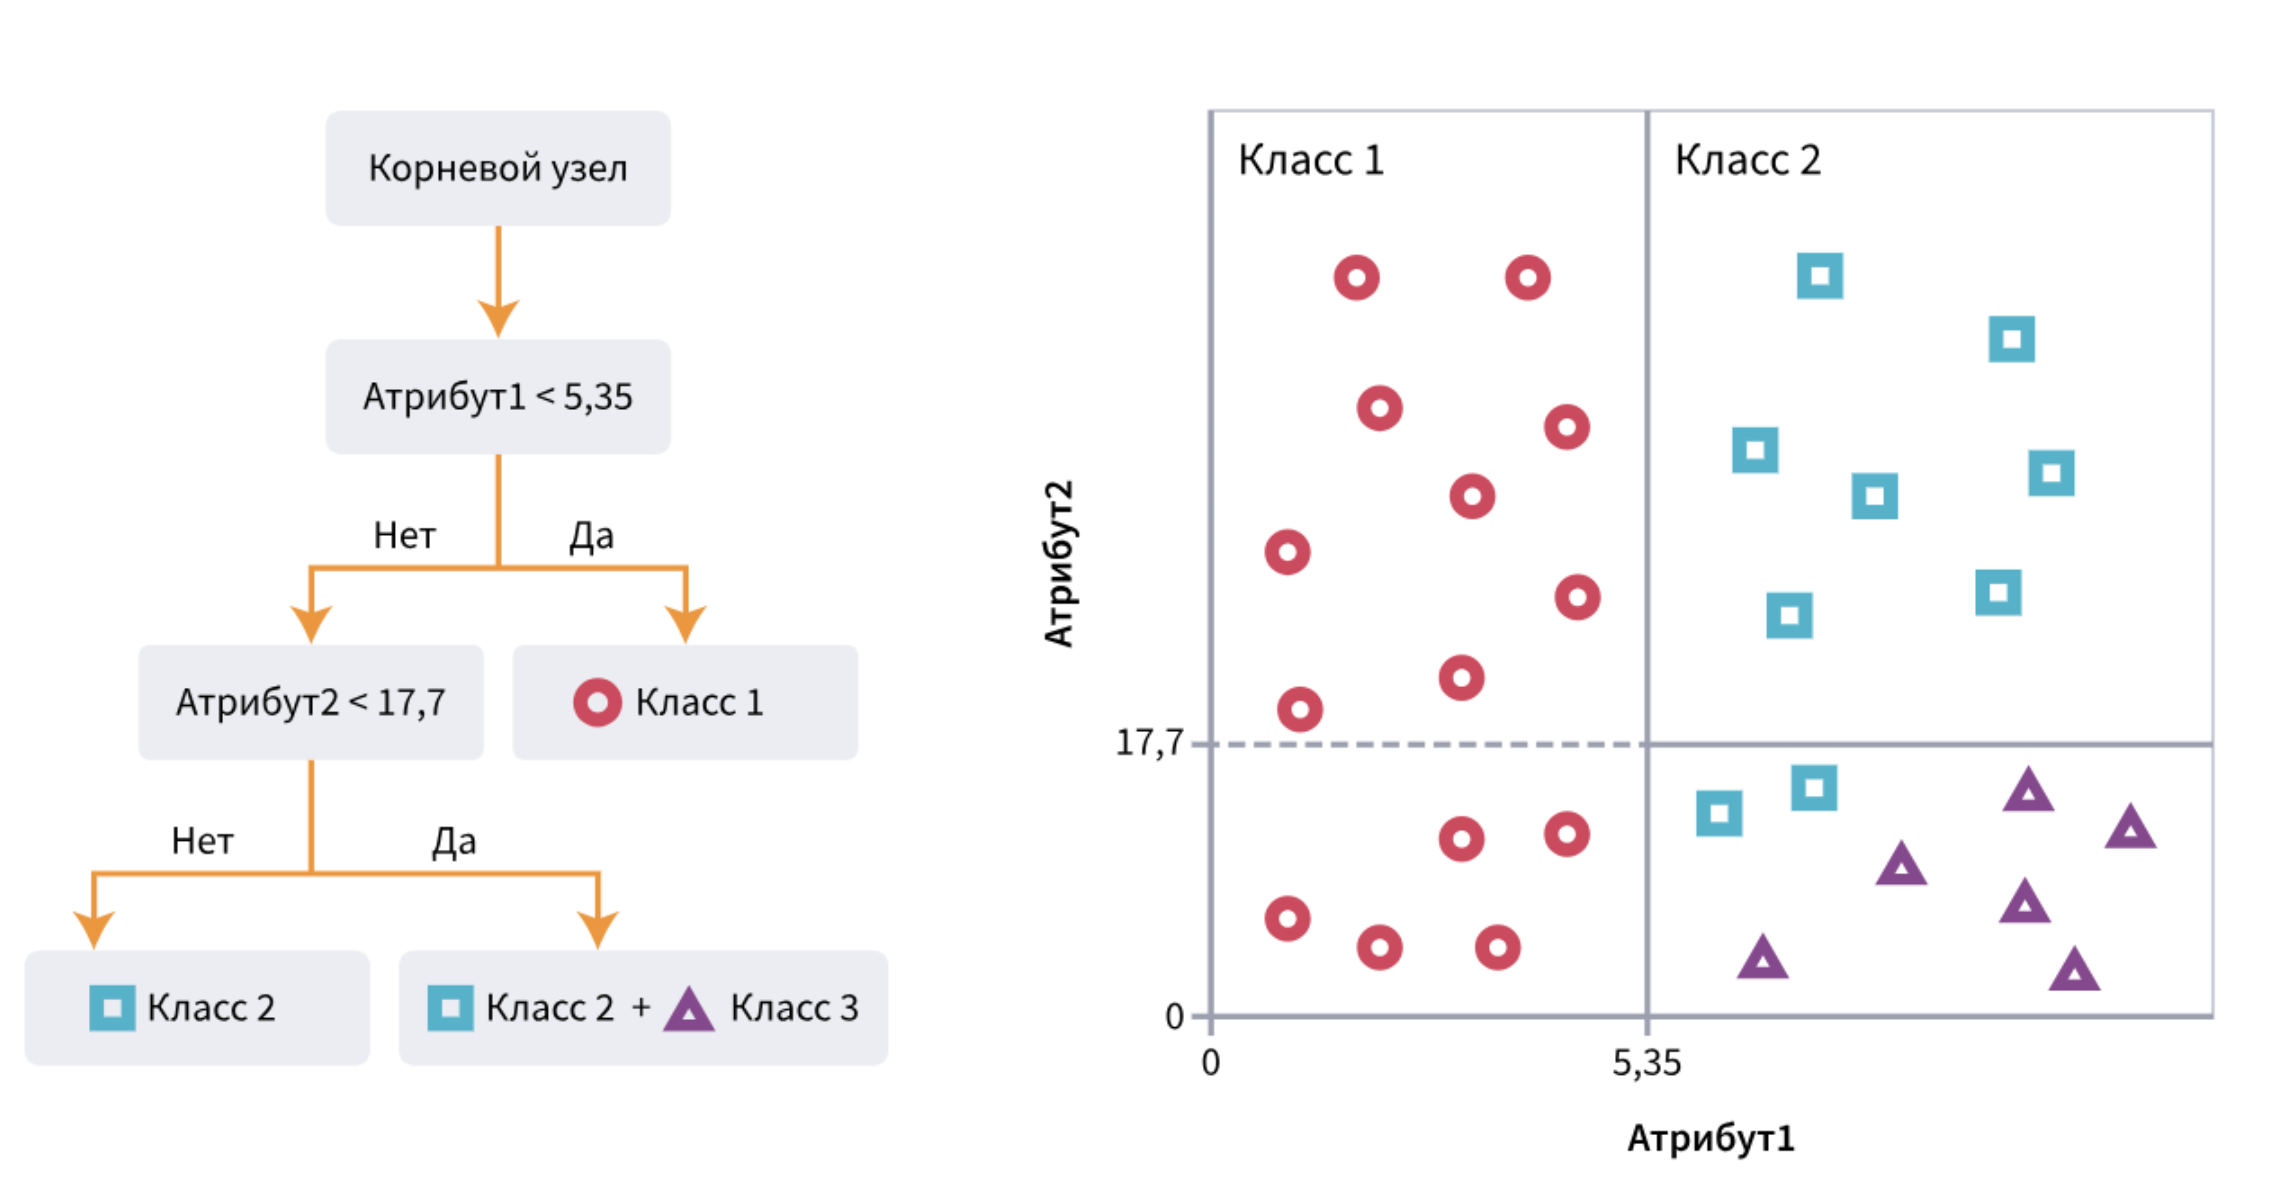



Например, "Если для объекта А признак 1 меньше, чем 5.35, то мы присуждаем ему значение класса 1, в противном случае объект отправляется в следующий узел и проходит новую проверку".


#### **Задача 2.** Построение решающего дерева

Повторите обучение-предсказание-оценку качества для решающего дерева. Выведите ошибку на обеих выборках: обучающей и тестовой.

In [30]:
!pip install graphviz

In [31]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz # Необходимо для визуализации

Точность (train): 1.0
F1 (train): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3177
           1       1.00      1.00      1.00       323

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500



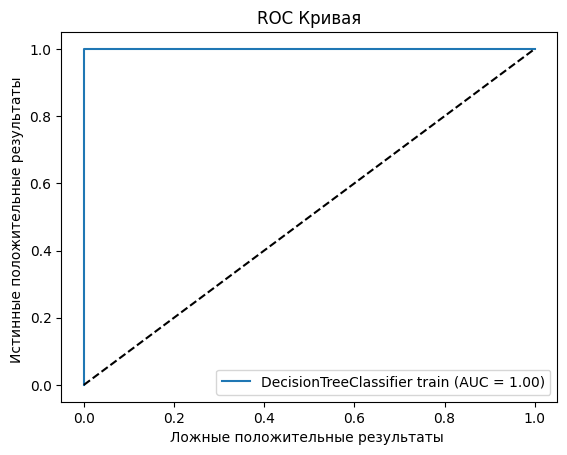

In [35]:
# Ваш код
model_tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')
# напишите обучение модели
model_tree.fit(X_train, y_train)

# получите предсказания
preds_train_tree = model_tree.predict(X_train)
preds_test_tree = model_tree.predict(X_test)

# получите предсказанные вероятности на трейне
y_prob_train_tree = model_tree.predict_proba(X_train)[:, 1]

evaluate(y_train, preds_train_tree, stage='train', model_name='DecisionTreeClassifier', need_report=True,
         need_roc_auc=True, y_prob=y_prob_train_tree)

Точность (test): 0.9786666666666667
F1 (test): 0.8947368421052632
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1343
           1       0.93      0.87      0.89       157

    accuracy                           0.98      1500
   macro avg       0.95      0.93      0.94      1500
weighted avg       0.98      0.98      0.98      1500



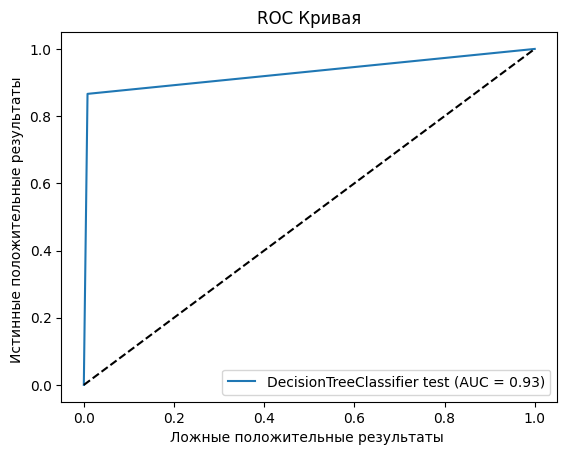

In [36]:
# получите предсказанные вероятности на тесте
y_prob_test_tree = model_tree.predict_proba(X_test)[:, 1]

evaluate(y_test, preds_test_tree, stage='test', model_name='DecisionTreeClassifier', need_report=True,
         need_roc_auc=True, y_prob=y_prob_test_tree)

Сравните полученные значения метрик с соответствующими значениями метрик у линейной модели. Какая из двух моделей является переобученной?

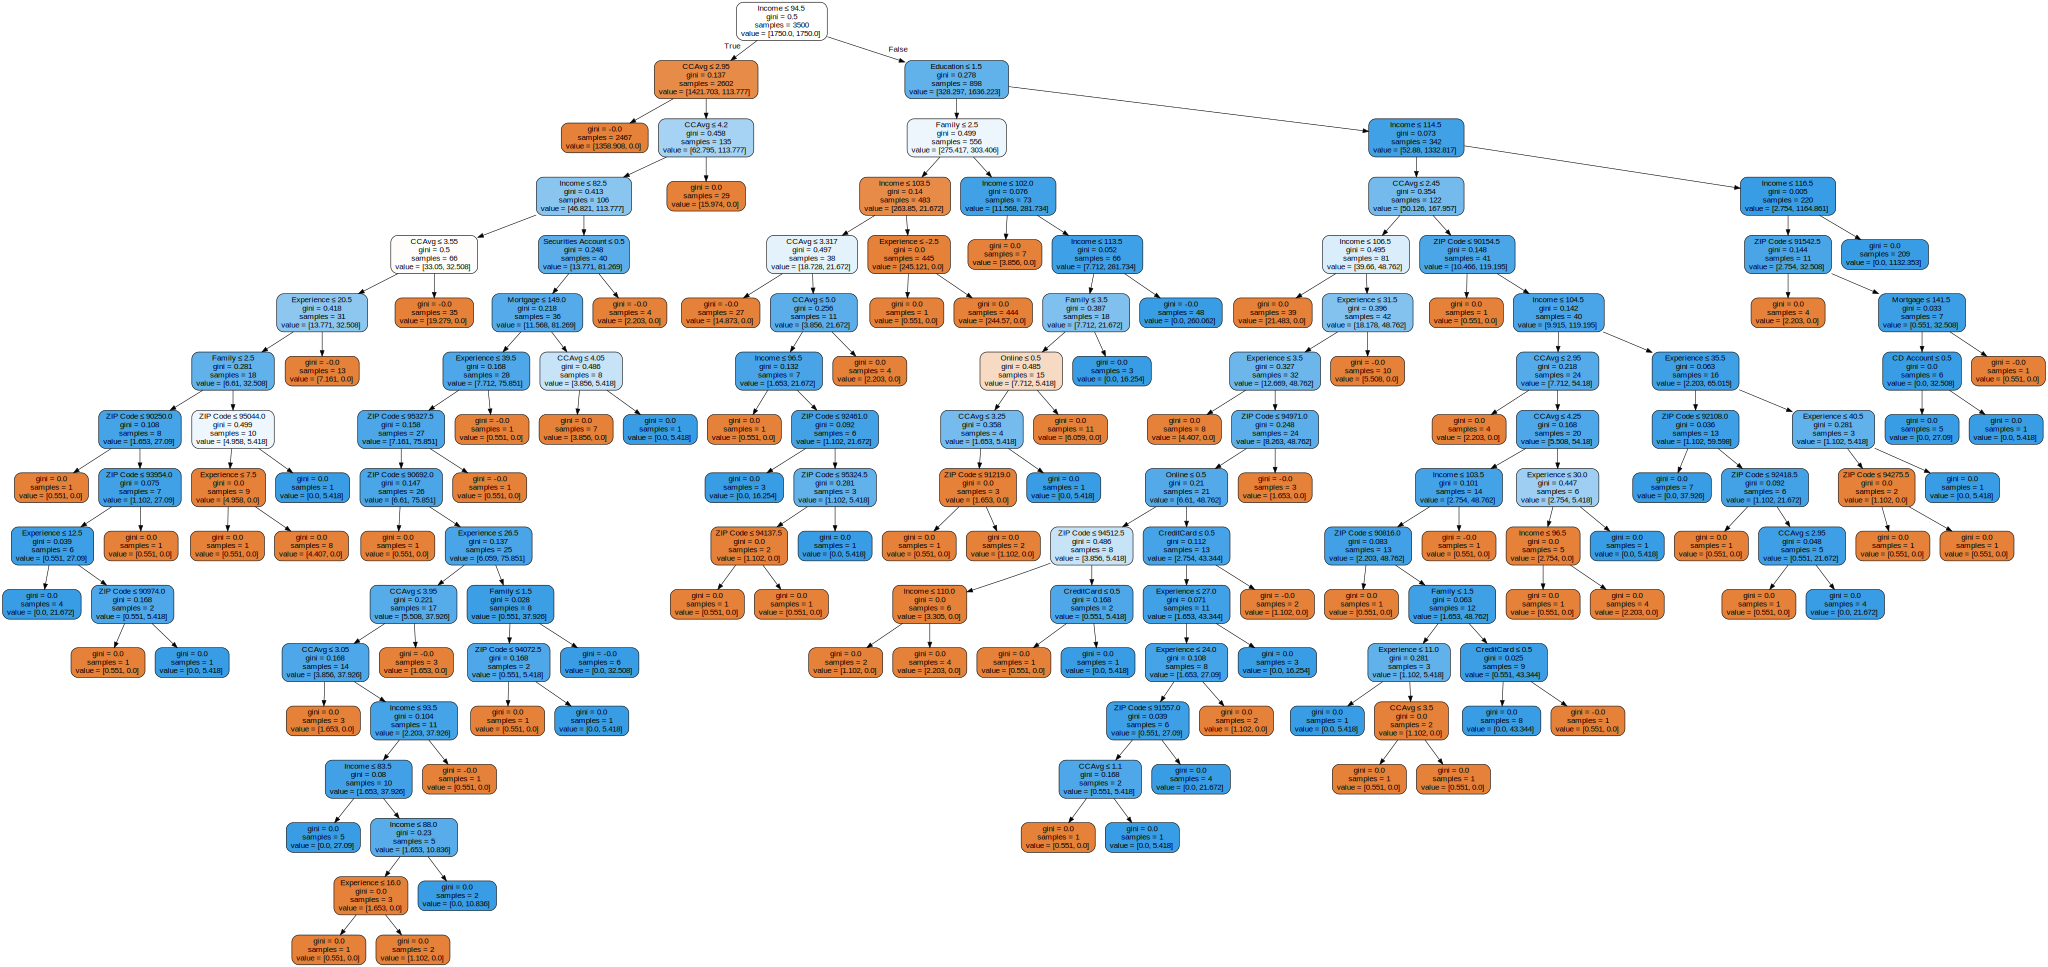

In [37]:
dot_data = export_graphviz(model_tree, feature_names=X.columns, filled=True, rounded=True, special_characters=True)
graphviz.Source(dot_data)

### Параметры и гиперпараметры модели

__Нашей целью__ при решении следующих задач будет попробовать различные алгоритмы машинного обучения на наших данных, и найти лучший алгоритм, а также лучшую его конфигурацию, то есть набор _гиперпараметров_ алгоритма.

__Гиперпараметрами__ называются величины, которые не настраиваются по обучающим данным в процессе обучения, и которые нужно задать до начала обучения алгоритма. Грамотный подбор гиперпараметров является одним из ключевых способов достижения хорошего уровня качества в машинном обучении. В следующих задачах мы познакомимся с гиперпараметрами различных алгоритмов и с процедурами их подбора.

Начнем с решающих деревьев!

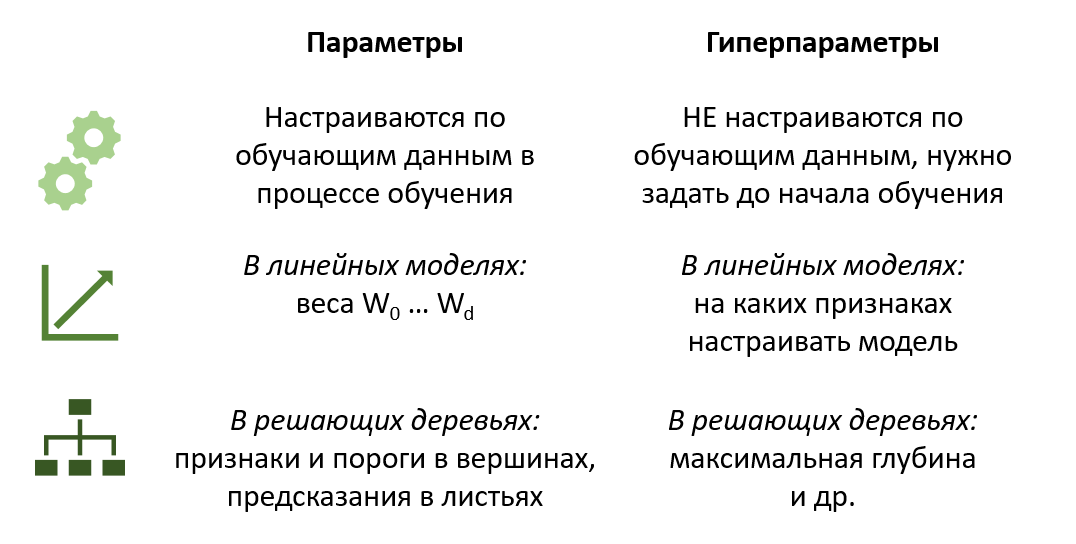

#### **Бонус: Задача 3.** Гиперпараметры решающего дерева

У решающих деревьев много гиперпараметров, ограничивающих их возможности запоминать обучающие данные и тем самым уменьшающих их переобучение. Одним из таких гиперпараметров является `max_depth` - максимальная глубина решающего дерева. Давайте попробуем несколько вариантов значений глубины и проследим динамику ошибки на обучающей и тестовой выборке.

Чтобы задать конкретную максимальную глубину X, укажите `max_depth=X` при создании модели. Попробуйте значения __1, 3, 5, 10, 20, 40, 100, None__, для каждого и повторите последовательность обучение-предсказание-оценивание качества.


_Примечание:_ в Python __None__ - буквально "ничего"; эта константа представляет отсутствие значения. `max_depth=None` означает неограниченную глубину дерева, поэтому, получая такую величину в качестве аргумента, дерево будет расширяться до тех пор, пока все листья не станут чистыми или не будут содержать менее `min_samples_split` объектов.


_Упрощенная версия:_ скопируйте код несколько раз и поменяйте требуемое значение.

_Стандартная версия:_ используйте цикл.

**Давайте попробуем выполнить данное задание с помощью модели Mistral. Чтобы воспользоваться чатом, есть несколько вариантов:**


1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого браузера;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.

Чтобы выполнить это задание вам необходимо скопировать пропмт без слова промпт в чат с мистралью.

**Промпт:**

Напиши код, который будет перебирать гиперпараметр длины дерева 1,3,5,10,20, None и повтори последовательность обучение-предсказание-оценивание и выведи красиво результаты на каждой итерации. Не забудь зафиксировать random_state=42 и учитывать несбалансированность данных при инициализации модели.

In [47]:
for max_depth in [1, 3, 5, 10, 14, 15, 16, 20, None]:

    model_tree = DecisionTreeClassifier(max_depth=max_depth, random_state=42, class_weight='balanced')
    model_tree.fit(X_train, y_train)

    preds_train_tree = model_tree.predict(X_train)
    preds_test_tree = model_tree.predict(X_test)

    print("Максимальная глубина дерева:", max_depth)
    print("F1 (train):", f1_score(y_train, preds_train_tree))
    print("F1 (test):", f1_score(y_test, preds_test_tree))
    print("depth: ", model_tree.get_depth())



Максимальная глубина дерева: 1
F1 (train): 0.49467649467649466
F1 (test): 0.5268817204301075
depth:  1
Максимальная глубина дерева: 3
F1 (train): 0.7559241706161137
F1 (test): 0.7623762376237624
depth:  3
Максимальная глубина дерева: 5
F1 (train): 0.8444444444444444
F1 (test): 0.8465909090909091
depth:  5
Максимальная глубина дерева: 10
F1 (train): 0.9714285714285714
F1 (test): 0.8974358974358975
depth:  10
Максимальная глубина дерева: 14
F1 (train): 0.9953775038520801
F1 (test): 0.8925081433224755
depth:  14
Максимальная глубина дерева: 15
F1 (train): 1.0
F1 (test): 0.898360655737705
depth:  15
Максимальная глубина дерева: 16
F1 (train): 1.0
F1 (test): 0.8947368421052632
depth:  16
Максимальная глубина дерева: 20
F1 (train): 1.0
F1 (test): 0.8947368421052632
depth:  16
Максимальная глубина дерева: None
F1 (train): 1.0
F1 (test): 0.8947368421052632
depth:  16


Выберите наилучшее значение максимальной глубины. Нужно выбирать по значению метрики на тестовой выборке - так, чтобы метрика качества была наибольшей.

Как правило, оптимальным получается значение где-то посередине: слишком большие значения приводят к переобучению (слишком сложное дерево запоминает обучающую выборку "наизусть"), слишком маленькие - к недообучению (слишком простое дерево не может извлечь зависимости из данных).

## Случайный лес

Решающие деревья сами по себе считаются слабым алгоритмом, однако если взять несколько решающих деревьев, то они будут "исправлять" ошибки друг друга, и все вместе достигнут хорошего качества. Такой подход называется _ансамблированием_, и одним из его вариантов является алгоритм под названием случайный лес (Random Forest).



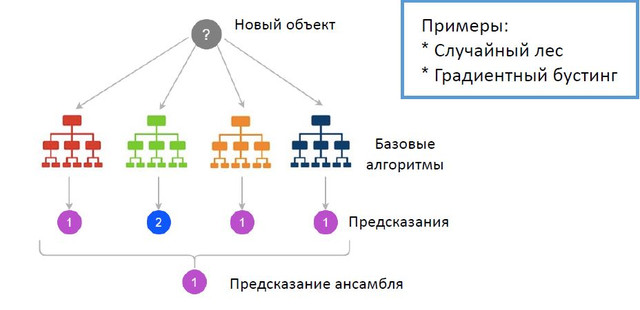

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [49]:
# Обучение
model_rf = RandomForestClassifier(random_state=42, class_weight='balanced')
model_rf.fit(X_train, y_train)

# Предсказания
preds_train_rf =  model_rf.predict(X_train)
preds_test_rf = model_rf.predict(X_test)

# Оценивание ошибки на трейне
y_prob_train_rf = model_rf.predict_proba(X_train)[:, 1]
evaluate(y_train, preds_train_rf, stage='train', model_name='RandomForestClassifier', need_report=True,
         need_roc_auc=False, y_prob=y_prob_train_rf)

# Оценивание ошибки на тесте
y_prob_test_rf = model_rf.predict_proba(X_test)[:, 1]
evaluate(y_test, preds_test_rf, stage='test', model_name='RandomForestClassifier', need_report=True,
         need_roc_auc=False, y_prob=y_prob_test_rf)

Точность (train): 1.0
F1 (train): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3177
           1       1.00      1.00      1.00       323

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500

Точность (test): 0.988
F1 (test): 0.94
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1343
           1       0.99      0.90      0.94       157

    accuracy                           0.99      1500
   macro avg       0.99      0.95      0.97      1500
weighted avg       0.99      0.99      0.99      1500



### **Бонус: Задача 4.** Подберите гиперпаметры для случайного леса

Обучите несколько случайных лесов с числом деревьев 3, 10, 100, 500 (всего 4 случайных леса). Задавать число деревьев можно так: `RandomForestClassifier(n_estimators=3)`. Используйте цикл или копирование кода.

**Давайте попробуем выполнить данное задание с помощью модели Mistral. Чтобы воспользоваться чатом, есть несколько вариантов:**


1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого браузера;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.


Попробуйте сами написать код по аналогии с заданием выше.

In [51]:
for n_estimators in [3, 10, 100, 500]:

    model_rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=n_estimators)
    model_rf.fit(X_train, y_train)

    preds_train_rf = model_rf.predict(X_train)
    preds_test_rf = model_rf.predict(X_test)

    print("Количество деревьев:", n_estimators)
    print("F1 (train):", f1_score(y_train, preds_train_rf))
    print("F1 (test):", f1_score(y_test, preds_test_rf))

Количество деревьев: 3
F1 (train): 0.9780564263322884
F1 (test): 0.8445945945945946
Количество деревьев: 10
F1 (train): 0.995334370139969
F1 (test): 0.9041095890410958
Количество деревьев: 100
F1 (train): 1.0
F1 (test): 0.94
Количество деревьев: 500
F1 (train): 1.0
F1 (test): 0.94


При каком числе деревьев в ансамбле достигается наилучшее качество по метрике на тестовой выборке?

### **Бонус: Задача 5.** Подбор максимальной глубины для случайного леса

В предыдущей задаче вы выбрали наилучшее значение числа деревьев в случайном лесе. Теперь подберите наилучшее значение максимальной глубины для случайного леса, используя выбранное число деревьев. Задать сразу два гиперпараметра можно так: `RandomForestClassifier(max_depth=1, n_estimators=1)`

In [55]:
for max_depth in [3, 5, 8, 10, 15, None]:

    model_rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=20, max_depth=max_depth)
    model_rf.fit(X_train, y_train)

    preds_train_rf = model_rf.predict(X_train)
    preds_test_rf = model_rf.predict(X_test)

    #print("depth: ", model_rf.get_depth()) # нет такого метода в RandomForest
    print("Максимальная глубина дерева:", max_depth)
    print("F1 (train):", f1_score(y_train, preds_train_rf))
    print("F1 (test):", f1_score(y_test, preds_test_rf))

Максимальная глубина дерева: 3
F1 (train): 0.5663716814159292
F1 (test): 0.5911708253358925
Максимальная глубина дерева: 5
F1 (train): 0.8471849865951743
F1 (test): 0.8490028490028491
Максимальная глубина дерева: 8
F1 (train): 0.9596412556053812
F1 (test): 0.910828025477707
Максимальная глубина дерева: 10
F1 (train): 0.9862595419847329
F1 (test): 0.9419354838709677
Максимальная глубина дерева: 15
F1 (train): 1.0
F1 (test): 0.9288135593220339
Максимальная глубина дерева: None
F1 (train): 1.0
F1 (test): 0.9225589225589226


## Градиентный бустинг

Главное отличие бустинга от случайного леса в том, что деревья в этом алгоритме строятся последовательно, и каждое следующее дерево исправляет ошибки предыдущего.

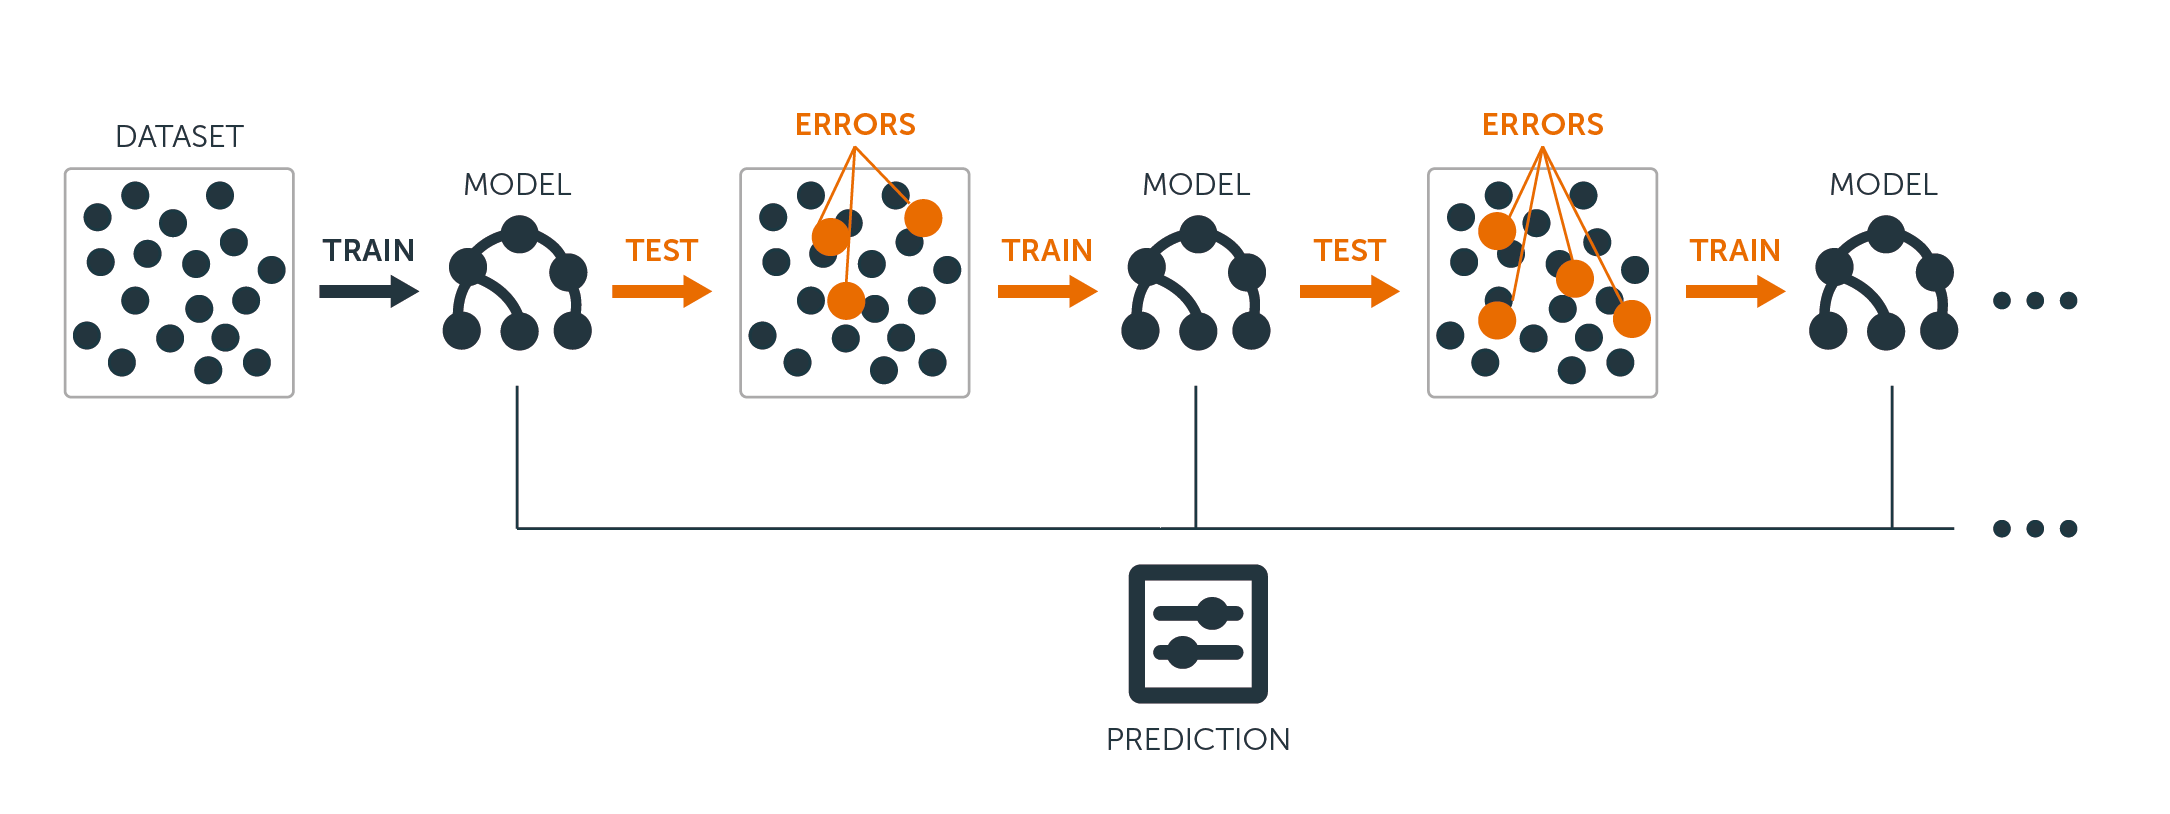

Для построения ансамбля в задаче классификации выбирается функция потерь — мера того, насколько текущие предсказания хороши. Например, это может быть логарифмическая потеря (log loss):

$$Loss(Y, \hat{Y}) = -\frac{1}{n} \sum_{i=1}^{n} \left[ y_i \log(\hat{y_i}) + (1 - y_i) \log(1 - \hat{y_i}) \right]$$

Для начала мы построим первое дерево $b_0$, которое призвано минимизировать функцию потерь. Его предсказания обозначим $\hat{Y}_{0}$.

$$b_0  \text{  минимизирует  }  Loss(Y, b(x))$$

$$\hat{Y}_{0} = b_0(x)$$

С большой вероятностью предсказания модели будут далеки от истинных значений. Поэтому мы построим новую модель $b_1$, которая будет прогнозировать отклонение реальных значений $Y$ от предсказаний $\hat{Y}_{0}$. То есть наша новая модель будет предсказывать ошибки старой, учиться на них.

$$b_1 \text{  минимизирует  } Loss(Y, \hat{Y}_{0} + b(x))$$

Таким образом, мы будем строить новые модели, которые корректируют предсказания предыдущих, до тех пор, пока не достигнем желаемых результатов. Так, на каждом шаге $t$ наши предсказания будут выглядеть следующим образом:

$$ \hat{Y}_t = \hat{Y}_{t-1} + \alpha \cdot b_t(x)$$

где:
- $\hat{Y}_t$ — предсказание на $t$-м шаге,
- $\hat{Y}_{t-1}$ — предсказание на предыдущем шаге,
- $\alpha$ — скорость обучения (learning rate),
- $b_t(x)$ — новая модель, которая обучается на ошибках предыдущих предсказаний.

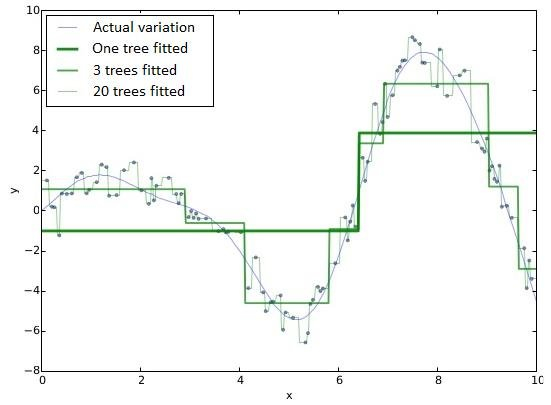

Попробуем применить алгоритм градиентного бустинга по уже опробованному плану действий

In [56]:
from sklearn.ensemble import GradientBoostingClassifier

In [57]:
# Обучение
model_boosting = GradientBoostingClassifier(random_state=42)
model_boosting.fit(X_train, y_train)

# Предсказания
preds_train_boost = model_boosting.predict(X_train)
preds_test_boost = model_boosting.predict(X_test)

# Оценивание ошибки на трейне
y_prob_train_boost = model_boosting.predict_proba(X_train)[:, 1]
evaluate(y_train, preds_train_boost, stage='train', model_name='GradientBoostingClassifier', need_report=True,
         need_roc_auc=False, y_prob=y_prob_train_boost)

# Оценивание ошибки на тесте
y_prob_test_boost = model_boosting.predict_proba(X_test)[:, 1]
evaluate(y_test, preds_test_boost, stage='test', model_name='GradientBoostingClassifier', need_report=True,
         need_roc_auc=False, y_prob=y_prob_test_boost)

Точность (train): 0.9948571428571429
F1 (train): 0.9714285714285714
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3177
           1       1.00      0.95      0.97       323

    accuracy                           0.99      3500
   macro avg       1.00      0.97      0.98      3500
weighted avg       0.99      0.99      0.99      3500

Точность (test): 0.99
F1 (test): 0.9511400651465798
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1343
           1       0.97      0.93      0.95       157

    accuracy                           0.99      1500
   macro avg       0.98      0.96      0.97      1500
weighted avg       0.99      0.99      0.99      1500



Метрика выросла, но давайте попробуем подобрать гиперпараметры у модели

In [58]:
best_f1_train_boost = -np.inf # обьект обозначающий бесконечно большое число
best_f1_test_boost = -np.inf
best_n_estimators_boost = ''
best_max_depth_boost = ''

for n_estimators in [3, 10, 100, 500]:
    for max_depth in [5, 10, 100, 500, None]:
        model_boosting = GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model_boosting.fit(X_train, y_train)

        preds_train_boost = model_boosting.predict(X_train)
        preds_test_boost = model_boosting.predict(X_test)

        train_f1_boost = f1_score(y_train, preds_train_boost)
        test_f1_boost = f1_score(y_test, preds_test_boost)

        if test_f1_boost > best_f1_test_boost:
            best_f1_train_boost = train_f1_boost
            best_f1_test_boost = test_f1_boost
            best_n_estimators_boost = n_estimators
            best_max_depth_boost = max_depth

In [59]:
print("Лучшее число деревьев", best_n_estimators_boost, "; Лучшая максимальная глубина дерева:", best_max_depth_boost)
print("F1 (train):", best_f1_train_boost)
print("F1 (test):", best_f1_test_boost)

Лучшее число деревьев 500 ; Лучшая максимальная глубина дерева: 5
F1 (train): 1.0
F1 (test): 0.9477124183006536


Нам удалось подобрать параметры так, чтобы наша метрика еще выросла, чем при использовании решающих деревьев!

### XGBoost

**XGBoost** - одна из самых популярных реализаций градиентного бустинга. В данной реализации есть минимальные отличия от классического градиентного бустинга, например, он использует сбалансированные деревья и добавляет в функцию потерь штраф за деревья со слишком большим количеством листьев.

In [60]:
from xgboost import XGBClassifier

In [61]:
# Обучение
model_xgb = XGBClassifier(random_state=42, class_weight='balanced')
model_xgb.fit(X_train, y_train)

# Предсказания
preds_train_xgb = model_xgb.predict(X_train)
preds_test_xgb = model_xgb.predict(X_test)

# Оценивание ошибки на трейне
y_prob_train_xgb = model_xgb.predict_proba(X_train)[:, 1]
evaluate(y_train, preds_train_xgb, stage='train', model_name='XGBClassifier', need_report=True,
         need_roc_auc=False, y_prob=y_prob_train_xgb)

# Оценивание ошибки на тесте
y_prob_test_xgb = model_xgb.predict_proba(X_test)[:, 1]
evaluate(y_test, preds_test_xgb, stage='test', model_name='XGBClassifier', need_report=True,
         need_roc_auc=False, y_prob=y_prob_test_xgb)

Точность (train): 1.0
F1 (train): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3177
           1       1.00      1.00      1.00       323

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500

Точность (test): 0.9906666666666667
F1 (test): 0.9548387096774194
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1343
           1       0.97      0.94      0.95       157

    accuracy                           0.99      1500
   macro avg       0.98      0.97      0.97      1500
weighted avg       0.99      0.99      0.99      1500



Давайте попробуем также подобрать параметры для XGBoost

In [62]:
best_f1_train_xgb = -np.inf
best_f1_test_xgb = -np.inf
best_n_estimators_xgb = ''
best_max_depth_xgb = ''

for n_estimators in [3, 10, 100]:
    for max_depth in [5, 10, 100, 500, None]:
        model_xgb = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth,random_state=42, class_weight='balanced')
        model_xgb.fit(X_train, y_train)

        preds_train_xgb = model_xgb.predict(X_train)
        preds_test_xgb = model_xgb.predict(X_test)

        train_f1_xgb = f1_score(y_train, preds_train_xgb)
        test_f1_xgb = f1_score(y_test, preds_test_xgb)

        if test_f1_xgb > best_f1_test_xgb:
            best_f1_train_xgb = train_f1_xgb
            best_f1_test_xgb = test_f1_xgb
            best_n_estimators_xgb = n_estimators
            best_max_depth_xgb = max_depth

In [63]:
print("Лучшее число деревьев", best_n_estimators_xgb, "; Лучшая максимальная глубина дерева:", best_max_depth_xgb)
print("F1 (train):", best_f1_train_xgb)
print("F1 (test):", best_f1_test_xgb)

Лучшее число деревьев 100 ; Лучшая максимальная глубина дерева: 100
F1 (train): 1.0
F1 (test): 0.9607843137254902


XGBoost еще больше повысил метрику, когда мы подобрали наилучшие гиперпараметры. При этом можно заметить, что XGBoost работает быстрее, чем обычный градиентный бустинг.

Давайте попробуем обучить более эффективную версию бустинга.

### CatBoost

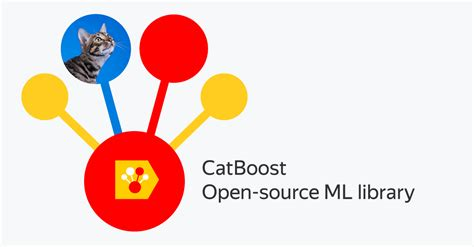

CatBoost - библиотека, содержащая модификацию модели градиентного бустинга от компании Яндекс. Основная особенность алгоритма - возможность эффективно обрабатывать категориальные переменные. Сейчас этот алгоритм считается одним из самых лучших решений для табличных данных!

In [64]:
! pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.6 MB/s eta 0:00:00


In [65]:
import catboost
from catboost import CatBoostClassifier

Точность (train): 1.0
F1 (train): 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3177
           1       1.00      1.00      1.00       323

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500

Точность (test): 0.9906666666666667
F1 (test): 0.9559748427672956
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1343
           1       0.94      0.97      0.96       157

    accuracy                           0.99      1500
   macro avg       0.97      0.98      0.98      1500
weighted avg       0.99      0.99      0.99      1500



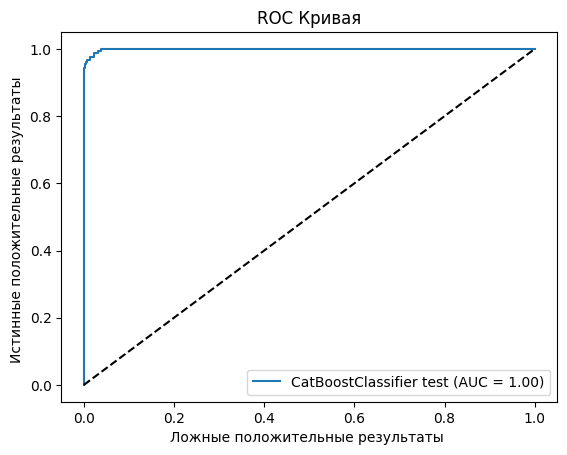

In [66]:
from sklearn.utils.class_weight import compute_class_weight

# Определяем классы и высчитываем для них веса для балансировки
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Обучение
model_catboost = CatBoostClassifier(verbose=0, class_weights=class_weights)
model_catboost.fit(X_train, y_train)

# Предсказания
preds_train_cat = model_catboost.predict(X_train)
preds_test_cat = model_catboost.predict(X_test)

# Оценивание ошибки на трейне
y_prob_train_cat = model_catboost.predict_proba(X_train)[:, 1]
evaluate(y_train, preds_train_cat, stage='train', model_name='CatBoostClassifier', need_report=True,
         need_roc_auc=False, y_prob=y_prob_train_cat)

# Оценивание ошибки на тесте
y_prob_test_cat = model_catboost.predict_proba(X_test)[:, 1]
evaluate(y_test, preds_test_cat, stage='test', model_name='CatBoostClassifier', need_report=True,
         need_roc_auc=True, y_prob=y_prob_test_cat)

А теперь давайте отдельно укажем модели, какие признаки являются категориальными, чтобы раскрыть весь потенциал алгоритма

In [67]:
# Обучение
model_catboost = CatBoostClassifier(verbose=0, random_state=42, class_weights=class_weights)
model_catboost.fit(X_train, y_train, cat_features=['Education'])

# Предсказания
preds_train_cat = model_catboost.predict(X_train)
preds_test_cat = model_catboost.predict(X_test)

# Оценивание ошибки на трейне
y_prob_train_cat = model_catboost.predict_proba(X_train)[:, 1]
evaluate(y_train, preds_train_cat, stage='train', model_name='CatBoostClassifier', need_report=False,
         need_roc_auc=False, y_prob=y_prob_train_cat)

# Оценивание ошибки на тесте
y_prob_test_cat = model_catboost.predict_proba(X_test)[:, 1]
evaluate(y_test, preds_test_cat, stage='test', model_name='CatBoostClassifier', need_report=False,
         need_roc_auc=False, y_prob=y_prob_test_cat)

Точность (train): 0.9994285714285714
F1 (train): 0.9969135802469136
Точность (test): 0.99
F1 (test): 0.9523809523809523


## Итоги

Итак, мы применили решающие деревья и ансамбли решающих деревьев, и теперь можем сделать следующие выводы:
* Предсказания решающих деревьев имеет меньшее значение метрик, однако ансамбль решающих деревьев повышает качество предсказания, и такой подход более устойчив к переобучению. Как правило, при работе с табличными данными на практике используют именно ансамбли решающих деревьев.
* Повысить качество ансамбля можно и нужно с помощью подбора его гиперпараметров.
* При этом у ансамблей есть недостатки - слабая интерпретируемость и относительно медленная скорость работы. Если эти два показателя являются приоритетными, то на практике обычно используют линейные модели.
* Catboost - одна из лучших моделей градиентного бустинга на данный момент.

### Дополнительный материал повышенной сложности. Подбор гиперпараметров с помощью Grid Search v2

Более удобный перебор гиперпараметров в `sklearn` реализован в `GridSearchCV`. Это более высокоуровневая реализация жадного перебора: в ней не нужно писать циклы по гиперпараметрам и вообще нужно писать меньше кода. Также ее преимуществом является то что качество алгоритма оценивается с помощью кросс валидации. Поэтому ее чаще используют на практике. Попробуем ей воспользоваться.

In [68]:
from sklearn.model_selection import GridSearchCV

Пример подбора гиперпараметров с помощью `GridSearchCV` для линейной модели:

In [69]:
# Модель, для которой мы хотим подобрать гиперпараметры
model_for_gs = LogisticRegression(random_state=42, class_weight='balanced')

# Какие варианты гиперпараметров нужно рассмотреть
params = {
    "fit_intercept": [True, False],
     # Можно указывать сразу несколько гиперпараметров и их вариантов
}

# Инициализируем алгоритм поиска гиперпараметров с оценкой качества через кросс-валидацию
gs = GridSearchCV(model_for_gs,
                  params,
                  cv=3,
                  verbose=5 # Печатать все промежуточные результаты
                 )

# Запуск GridSearchCV - стандартный вызов функции fit
gs.fit(X_train, y_train)

print("Лучшие гиперпараметры:", gs.best_params_)
print("Лучшее значение метрики:", gs.best_score_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV 1/3] END ................fit_intercept=True;, score=0.864 total time=   0.1s
[CV 2/3] END ................fit_intercept=True;, score=0.863 total time=   0.1s
[CV 3/3] END ................fit_intercept=True;, score=0.903 total time=   0.1s
[CV 1/3] END ...............fit_intercept=False;, score=0.864 total time=   0.1s
[CV 2/3] END ...............fit_intercept=False;, score=0.863 total time=   0.0s
[CV 3/3] END ...............fit_intercept=False;, score=0.901 total time=   0.1s
Лучшие гиперпараметры: {'fit_intercept': True}
Лучшее значение метрики: 0.8765790024217536


В процессе печатаются промежуточные результаты: для каждой комбинации гиперпараметров - значения метрики качества для трех запусков модели (так как мы запросили 3 блока в кросс-валидации, `cv=3`).

### **Бонус: Задача 6.** Примените `GridSearchCV` к `GradientBoostingClassification`.

Рассмотрите значения `max_depth` __1, 3, 10__ и значения `n_estimators` __5, 20, 100__.

**Давайте попробуем выполнить данное задание с помощью модели Mistral. Чтобы воспользоваться чатом, есть несколько вариантов:**


1. Кликните на данную ссылку https://chat.mistral.ai/;
2. Скопируйте данную ссылку https://chat.mistral.ai/ и вставьте ее в поисковую строку любого браузера;
3. На рабочем столе нажмите на ссылку, которая ведет к чату.

Чтобы выполнить это задание вам необходимо скопировать пропмт без слова промпт в чат с мистралью.

**Промпт:**

Примени GridSearchCV к GradientBoostingClassification. Рассмотри значения `max_depth` __1, 3, 10__ и значения `n_estimators` __5, 20, 100__. Выведи лучшие гиперпараметры и метрику.


In [73]:
# Ваш код

#import numpy as np
#from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.metrics import classification_report

# Предположим, что X и y уже определены
# X - это матрица признаков, y - это вектор целевых значений

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Определение параметров для GridSearchCV
param_grid = {
    'max_depth': [1, 3, 10],
    'n_estimators': [5, 20, 100]
}

# Инициализация модели GradientBoostingClassifier
model = GradientBoostingClassifier(random_state=42)

# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Обучение модели с использованием GridSearchCV
grid_search.fit(X_train, y_train)

# Лучшие гиперпараметры
best_params = grid_search.best_params_

# Лучшая метрика (accuracy)
best_score = grid_search.best_score_

# Вывод лучших гиперпараметров и метрики
print("Best Parameters:", best_params)
print("Best Accuracy:", best_score)

# Оценка модели с лучшими гиперпараметрами на тестовой выборке
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Вывод отчета классификации
print("Classification Report:")
print(classification_report(y_test, y_pred))


Best Parameters: {'max_depth': 3, 'n_estimators': 100}
Best Accuracy: 0.9845714285714285
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1343
           1       0.97      0.93      0.95       157

    accuracy                           0.99      1500
   macro avg       0.98      0.96      0.97      1500
weighted avg       0.99      0.99      0.99      1500



In [74]:
preds_train = gs.predict(X_train)
preds_test = gs.predict(X_test)


print("F1 (train):", f1_score(y_train, preds_train))
print("F1 (test):", f1_score(y_test, preds_test))

F1 (train): 0.5714285714285714
F1 (test): 0.5857740585774058
